In [1]:
import pandas as pd
from tqdm import tqdm
import time
import litellm
import os
import numpy as np
tqdm.pandas()
#from .autonotebook import tqdm as notebook_tqdm
from sacrebleu.metrics import BLEU, CHRF, TER
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import random
random.seed(42)
from evaluate import load
bertscore = load("bertscore")
chrf = load("chrf")

from litellm import completion
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
import json
from collections import Counter
from common import *

# Set the Seaborn style and color palette
sns.set_theme(style="whitegrid")
custom_palette = sns.color_palette("Set2")

# Danish pairwise fluency ratings 

The data comes from my manual fluency corrections of 98 long Flores200 dev sentences where the source sentence was translated to French using Opus and then Danish using GPT-4o. The fluency quality was generally high and I deleted 32 perfectly fluent backtranslated sentences to get 98 dysfluent samples that were minimally corrected to be fluent. The majority of the errors were too direct translations. Examples of errors and corrections

## Objectives
I explore whether strong models can distinguish between fluent and dysfluent sentences. 

## Method
Single prompts for OpenAI models, balanced with which is candidate A and B
Batch prompts for Gemini 2.5 and Sonnet 3.7 where the position of the fluent and dysfluent samples have been randomized
Temperature 0.1

## Observations
- None of the models are good enough at differentiating
- Even the good models are not too far from the random baseline - this is surprising
- We do observe the expected hierarchy between smaller models and larger models, but the differences are miniscule compared to other tasks. This is also surprising. The differences between many models are likely not statistically different
- There is no conclusive pattern is whether chain of thought helps. The difference may not even be statistically different. For the "thinking" models it makes sense, because even the non-cot setting are cot.

## Conclusions from this notebook
- The fluency task is hard - even for large models
- A fluency-annotated dataset like mine could be a good eval that could challenge models for some time still
- If my findings from Danish generalizes to other languages, we can not use an LLM as judge to filter fluent from dysfluent sentences

## Next steps:
- I can try looking at the logprobs, but I doubt it will change the results much
- I can try giving it the original translation
- I can try to see if the models are better at editing than distinguishing fluent from dysfluent, but I doubt it, since that is a harder task

# Data examples
Da lavvandet åbnede et område langs Mystic-floden langs den nordøstlige del af halvøen, udvidede de hurtigt hegnet med en kort stenmur mod nord, der endte ved vandkanten på en lille strand.

Corrections
kort -> lav

Studerende kan også stille spørgsmål til instruktørerne når som helst på dagen og forvente rimeligt hurtigt svar, i stedet for at vente til det næste møde ansigt til ansigt.

Corrections:
Deleted 'på dagen' as is sounds it too literally meaning during the daytime instead of meaning 'any time'
replaced 'ansigt til ansigt' with 'det næste fysisk møde'. While 'ansigt til ansigt' is used in Danish, it sounds more confrontational than in English. "et fysisk møde' sounds more neutral. 


In [2]:
print('hello')

hello


In [3]:
# set system variables
! source ~/.bashrc

In [4]:
def create_rating_prompt(candidate_A:str, candidate_B:str, cot=False):

    prompt = f"""Here are two sentences. One is more fluent than the other. Select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness or the content of the text, only its use of language.
    Return only the letter of the candidate, i.e. A or B. Say nothing else.
    A: {candidate_A}
    B: {candidate_B}
    """

    prompt_cot = f"""Here are two sentences. One is more fluent than the other. Select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness or the content of the text, only its use of language.
    Return only the letter of the candidate, i.e. A or B between these tags: <winner></winner> and a reason for your choice between these tags <reason> </reason>. Example: <winner>A</winner> <reason>The text contains an anglicism in the form of non standard verb-particle ('tjekke ned') construction and a non-standard Danish word: (radioactive) </reason>Say nothing else.
    A: {candidate_A}
    B: {candidate_B}
    """

    if cot ==False:
        return prompt
    else: 
        return prompt_cot

def create_minimal_rating_prompt(candidate_A:str, candidate_B:str):
    prompt = f"""A: {candidate_A}
    B: {candidate_B}
    """
    return prompt

def create_batch_prompt(dict_of_prompts: dict, cot=False):
    # Create a properly formatted string representation of the dictionary
    dict_as_string = str({k: v for k, v in dict_of_prompts.items()})
    
    prompt = f"""Below you will see a dictionary of indices and prompts. For each index, select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness, or the content of the text, only its use of language.
    Punish the candidate that contains anglicisms, ungrammaticality, translationese, or other non-native language features.
    For each index, return only the letter of the candidate, i.e. A or B. Say nothing else.
    Return a dictionary like this: {{0: 'A', 1: 'B', 2: 'A', ...}}
    {dict_as_string}
    """

    prompt_cot = f"""Below you will see a dictionary of indices and prompts. For each index, select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness, or the content of the text, only its use of language.
    Punish the candidate that contains anglicisms, ungrammaticality, translationese, or other non-native language features.
    For each index, return the letter of the candidate, i.e. A or B, as well as the reason for the choice.
    Return a dictionary like this:
    {{
    0: {{'winner': 'A', 'reason': 'Candidate B contains an anglicism in the form of non standard verb-particle construction ('tjekke ned')'}},
    1: {{'winner': 'B', 'reason': 'Candidate A contains a non-standard Danish word: (radioactive)'}},
    ...
    }}
    {dict_as_string}
    """
    if cot:
        return prompt_cot
    else:
        return prompt

def create_prompt_rating(text:str):
    prompt=f"""Grade the following sentence according to this grading rubric. 
    <sentence>{text}</sentence>
    
    **Criterion **
    Danish Language Fluency Grading Rubric

    1 Point: Minimal Fluency

    Grammar: Technically grammatical but with pervasive errors in most areas (gender, number, tense, etc.)
    Vocabulary: Very basic vocabulary with significant repetition and many direct translations
    Pronunciation/Flow: Text is choppy and disconnected, would sound extremely unnatural to native speakers
    Sentence Structure: Almost exclusively simple or fragmented sentences arranged in an unnatural sequence
    Idioms: No awareness of Danish cultural context in language use

    2 Points: Basic Fluency

    Grammar: Frequent grammatical errors in article use, and verb tenses, though main meaning is understandable
    Vocabulary: Limited vocabulary with repetition and occasional use of non-Danish words or direct translations
    Pronunciation/Flow: Text reads with a distinctly non-Danish cadence and would sound unnatural when read aloud
    Sentence Structure: Predominantly simple sentences with awkward attempts at complexity
    Idioms: Minimal awareness of Danish idioms and verbal phrases

    3 Points: Intermediate Fluency

    Grammar: Some noticeable grammatical errors, particularly with complex structures, but meaning remains clear
    Vocabulary: Adequate vocabulary for most situations, but limited idiomatic expressions and some repetition
    Pronunciation/Flow: Text has a somewhat unnatural rhythm that would be noticeable to native speakers
    Sentence Structure: Mix of simple and complex sentences, but reliance on certain patterns
    Idioms: Some awareness of Danish idioms and verbal phrases, but still some errors that are directly translated from English, e.g., 'jeg bryder problemet ned'

    4 Points: Advanced Fluency

    Grammar: Very few minor grammatical errors that wouldn't distract a native speaker
    Vocabulary: Broad vocabulary with good use of idioms, though occasional imprecise word choice
    Pronunciation/Flow: Text flows naturally with only occasional awkward phrasing
    Sentence Structure: Good variety of complex sentence structures with minor awkwardness
    Idioms: Generally appropriate use of Danish idioms and verbal phrases with occasional slight misuse

    5 Points: Native-Like Fluency

    Grammar: Perfect grammatical control with no errors in noun gender, verb conjugation, or word order
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Pronunciation/Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions.

    ** Format 
    List all errors between the tags <reason> </reason>. In case of no fluency errors, write 'None' between the tags.
    Give your score (1-5) between the tags <score> </score>
    """

    return prompt

In [2]:
df = pd.read_json('../translations/back_translation/danish_fluency_edits_llm.jsonl', lines=True)

In [129]:

cot = False
models = ['gpt-4-0125-preview', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
models = ['gemini/gemini-2.0-flash', 'gemini/gemini-1.5-pro']
for model in models:
    df[f"{model}_{'cot' if cot else 'pairwise'}"] = df.progress_apply(lambda x: run_rating(translation = x['back_translated_to_danish'], correction=x['human_edited'], model=model, cot=cot), axis=1)
    #print(model, df[f'{model}_pairwise'].describe())

  0%|          | 0/98 [00:00<?, ?it/s]16:12:59 - LiteLLM:DEBUG: utils.py:301 - 

16:12:59 - LiteLLM:DEBUG: utils.py:301 - Request to litellm:
16:12:59 - LiteLLM:DEBUG: utils.py:301 - litellm.completion(model='gemini/gemini-2.0-flash', messages=[{'role': 'user', 'content': 'Here are two sentences. One is more fluent than the other. Select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness or the content of the text, only its use of language.\n    Return only the letter of the candidate, i.e. A or B. Say nothing else.\n    A: Siden sin oprettelse er The Onion blevet et sandt parodiimperium med en trykt udgave, en hjemmeside, der tiltrak 5.000.000 unikke besøgende i oktober, personlige annoncer, et 24-timers nyhedsnetværk, podcasts og et nyligt lanceret verdensatlas kaldet Our Dumb World.\n    B: Siden sin oprettelse er The Onion blevet et sandt parodiimperium med en trykt udgave, en hjemmeside, der tiltrak 5.000.000 unikke besøgende i oktob


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.



ServiceUnavailableError: litellm.ServiceUnavailableError: VertexAIException - {
  "error": {
    "code": 503,
    "message": "The service is currently unavailable.",
    "status": "UNAVAILABLE"
  }
}


In [ ]:
df.to_json('../translations/back_translation/danish_fluency_edits_llm.jsonl', lines=True, orient='records')

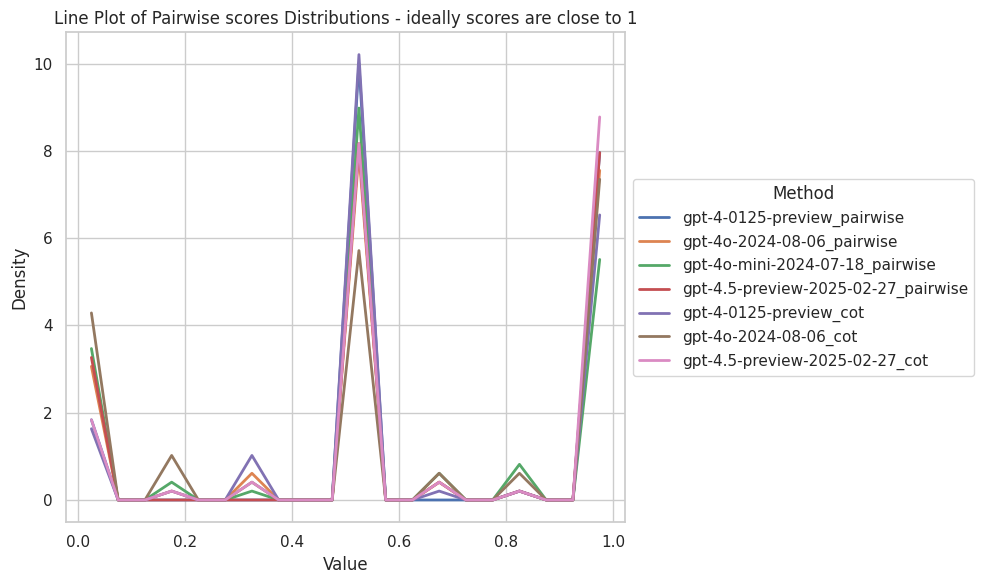

In [26]:
import numpy as np
import matplotlib.pyplot as plt

columns = ['gpt-4-0125-preview_pairwise', 'gpt-4o-2024-08-06_pairwise', 'gpt-4o-mini-2024-07-18_pairwise', 
           'gpt-4.5-preview-2025-02-27_pairwise', 'gpt-4-0125-preview_cot', 'gpt-4o-2024-08-06_cot',
           'gpt-4.5-preview-2025-02-27_cot']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions for each column
for col in columns:
    counts, bin_edges = np.histogram(df[col], bins=20, density=True)  # Histogram data
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    ax.plot(bin_centers, counts, label=col, linewidth=2)  # Line plot of histogram

# Add legend, labels, and title
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title('Line Plot of Pairwise scores Distributions - ideally scores are close to 1')

# Place legend outside the plot
ax.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Adjust layout to make space for the legend
plt.tight_layout()

# Show the plot
plt.show()

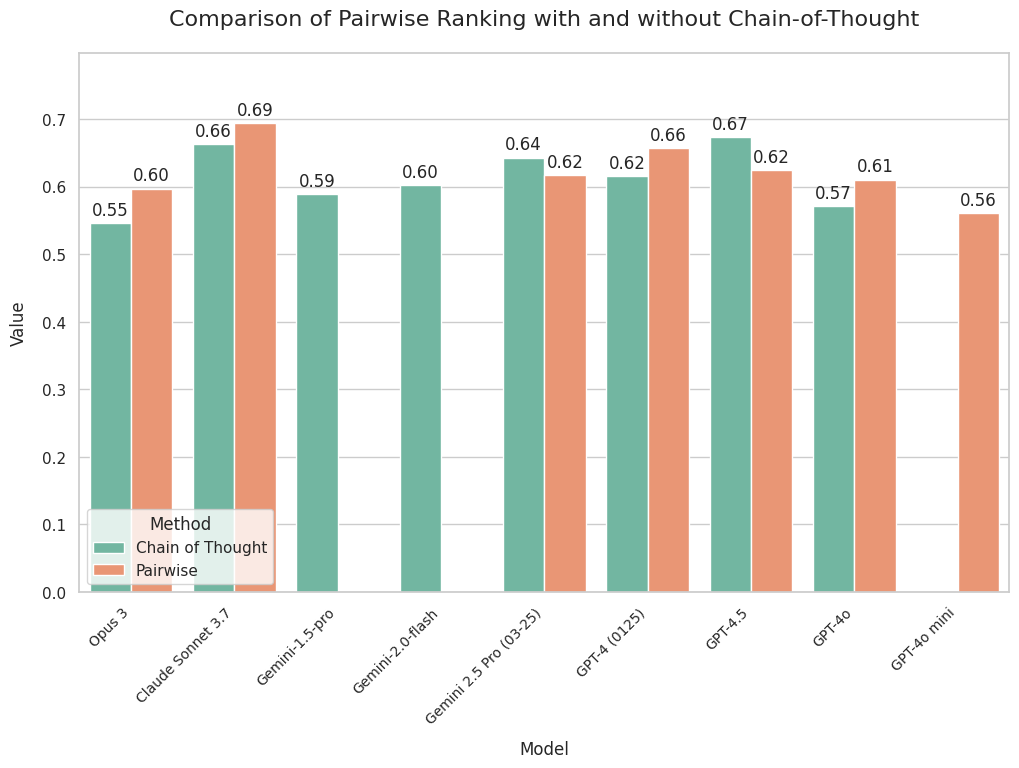

In [56]:
# Get the columns we need
pairwise_cols = [col for col in df.columns if col.endswith('_pairwise')]
cot_cols = [col for col in df.columns if col.endswith('_cot')]

# Assuming df is your DataFrame with the columns you mentioned
# First, let's count the occurrences of 'A' in each column
pairwise_cols = [col for col in df.columns if col.endswith('_pairwise')]
cot_cols = [col for col in df.columns if col.endswith('_cot')]

# Create a new DataFrame for plotting
plot_data = []
for col in sorted(pairwise_cols + cot_cols):
    model_base = '_'.join(col.split('_')[:-1])  # Extract base model name without the suffix
    method = 'Pairwise' if col.endswith('_pairwise') else 'Chain of Thought'
    # Use the mean value directly since columns contain floats
    plot_data.append({
        'Model': model_base,
        'Method': method,
        'Value': df[col].mean()  # Use mean if there are multiple rows
    })

plot_df = pd.DataFrame(plot_data)

# Create more readable model names
model_mapping = {
    'gpt-4-0125-preview': 'GPT-4 (0125)',
    'gpt-4o-2024-08-06': 'GPT-4o',
    'gpt-4o-mini-2024-07-18': 'GPT-4o mini',
    'gpt-4.5-preview-2025-02-27': 'GPT-4.5',
    'gemini/gemini-1.5-pro': 'Gemini-1.5-pro',
    'gemini/gemini-2.0-flash': 'Gemini-2.0-flash',
    'claude_sonnet_37': 'Claude Sonnet 3.7',
    'gemini_25': 'Gemini 2.5 Pro (03-25)',
    'Opus_3': 'Opus 3'
}

plot_df['Model'] = plot_df['Model'].map(lambda x: model_mapping.get(x, x))

# Create the plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_df,
    x='Model',
    y='Value',
    hue='Method',
    palette=custom_palette[:2],
    errorbar=None
)

# Customize the plot
plt.title('Comparison of Pairwise Ranking with and without Chain-of-Thought', fontsize=16, pad=20)
plt.xlabel('Model', fontsize=12, labelpad=10)
plt.ylabel('Value', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, plot_df['Value'].max() * 1.15)  # Add some space above the bars

# Add text annotations for values
for i, row in enumerate(ax.containers):
    ax.bar_label(row, fmt='%.2f', padding=3)

# Adjust legend
plt.legend(title='Method', loc='lower left', frameon=True)


In [52]:
# Make a batch prompt to feed into claude
cot = False
# Example usage
df = add_rating_prompt_column(df, 'back_translated_to_danish', 'human_edited')

# add the letter of the human edited version
df['human_edited_letter'] = df.apply(
    lambda row: 'B' if row['backtranslated_is_A'] else 'A', axis=1
)

batch = df[['prompt']].to_dict(orient='index')
prompt = create_batch_prompt(batch, cot=cot)
print(prompt)

Below you will see a dictionary of indices and prompts. For each index, select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness, or the content of the text, only its use of language.
    Punish the candidate that contains anglicisms, ungrammaticality, translationese, or other non-native language features.
    For each index, return only the letter of the candidate, i.e. A or B. Say nothing else.
    Return a dictionary like this: {0: 'A', 1: 'B', 2: 'A', ...}
    {0: {'prompt': 'A: Siden sin oprettelse er The Onion blevet et sandt parodiimperium med en trykt udgave, en hjemmeside, der tiltrak 5.000.000 unikke besøgende i oktober, personlige annoncer, et 24-timers nyhedsnetværk, podcasts og et nyligt lanceret verdensatlas kaldet Our Dumb World.\n    B: Siden sin oprettelse er The Onion blevet et sandt parodiimperium med en trykt udgave, en hjemmeside, der tiltrak 5.000.000 unikke besøgende i oktober måned, personlige annoncer, et 24-time

In [ ]:
claude37sonnet_cot_a = {
0: {'winner': 'B', 'reason': 'Candidate B includes "måned" after "oktober", which is more natural in Danish when specifying a month'},
1: {'winner': 'A', 'reason': 'Candidate B contains an awkward sentence structure with "for et par uger siden" at the beginning and uses "transplantationer" instead of the more appropriate "bestikkelse"'},
2: {'winner': 'B', 'reason': 'Candidate B uses the idiomatic expression "holde lav profil" instead of the direct translation "holde sig så lavt som muligt" in A, which sounds like translationese'},
3: {'winner': 'B', 'reason': 'Candidate B uses "almindelig blækpatronprinter" which is more natural Danish than the anglicism "standard inkjet-printere" in A'},
4: {'winner': 'B', 'reason': 'Candidate B has a more natural sentence structure by removing the redundant "i dag" that appears in candidate A'},
5: {'winner': 'A', 'reason': 'Candidate A uses "helbredet" which is more appropriate in this context than "velfærden" in B, which feels like a direct translation of the English word "welfare"'},
6: {'winner': 'B', 'reason': 'Candidate B uses "til overvejelse for" which is more natural than "som mulige kandidater for" in A, which sounds like translationese'},
7: {'winner': 'B', 'reason': 'Candidate B uses "har flyruter til" instead of the direct translation "tilbyder forbindelser til" in A, which sounds like translationese of "offer connections to"'},
8: {'winner': 'A', 'reason': 'Both candidates are identical, but marking A as winner per instructions to select one'},
9: {'winner': 'B', 'reason': 'Candidate B uses the more natural Danish phrase "kom herover" instead of just "komme" in A, and has better sentence structure'},
10: {'winner': 'B', 'reason': 'Candidate B uses "organisationens historie" which is more specific and natural than the vague "fortiden" in A, which sounds like a direct translation of "the past"'},
11: {'winner': 'A', 'reason': 'Candidate A correctly refers to "Black Beauty" as the name of the car, while B mistranslates it as "hans lave sorte skønhed" which misunderstands the context'},
12: {'winner': 'B', 'reason': 'Candidate B uses "langs" instead of "fulgte" and "foran" instead of "forbi" which are more natural Danish prepositions in this context'},
13: {'winner': 'A', 'reason': 'Candidate A uses "tilslutte sig" and "tilbudte privilegier" which are more correct than B\'s "rejse med" and the ungrammatical "tilbuddene" (should be "tilbud")'},
14: {'winner': 'B', 'reason': 'Candidate B has more natural Danish syntax, avoiding the redundant "dem" and using the preposition "af" instead of the less natural "som" in A'},
15: {'winner': 'A', 'reason': 'Candidate A uses "hurtigere" which is more appropriate than "hurtigt" in B, and uses better sentence structure with "halveret i forhold til" versus "halvdelen af dem"'},
16: {'winner': 'B', 'reason': 'Candidate B correctly uses "digtene" for epic poems instead of the less appropriate "eposserne" in A, and uses the more natural "sandsynligvis" instead of "nok"'},
17: {'winner': 'B', 'reason': 'Candidate B uses the more natural "fordi" instead of repeating "da", better Danish grammar with "autoriteter" (plural), and the phrase "mere almindelig adfærd" is more natural than "normale metoder"'},
18: {'winner': 'B', 'reason': 'Candidate B has a more natural word order and flow in Danish, and includes "som" before "turist eller forretningsrejsende" which makes the sentence clearer'},
19: {'winner': 'B', 'reason': 'Candidate A contains the incorrect verb "registerer" instead of the correct "rapporterer" used in B, and A is missing "og" between "bruger" and "rapporterer"'},
20: {'winner': 'B', 'reason': 'Candidate B has more natural Danish syntax and removes the unnecessary repetition of the subject "han" found in A'},
21: {'winner': 'A', 'reason': 'Candidate A uses "en nuklear industri" which is more correct than "en atomenergi virksomhed" in B, which sounds unnatural and should be a compound word if used'},
22: {'winner': 'B', 'reason': 'Candidate B uses "mindst 40 andre familier" which is more natural than "40 andre familier eller flere" in A, and includes "samme" before "boligsnyd" which adds clarity'},
23: {'winner': 'B', 'reason': 'Candidate B uses the proper name "Planned Parenthood" instead of the translated "familieplanlægning" in A, which is more appropriate for an organization name'},
24: {'winner': 'B', 'reason': 'Candidate B uses "forestille sig" instead of "huske" (which means remember) and uses "hedengangne slag" instead of the less natural "slag, der for længst er forsvundet" in A'},
25: {'winner': 'B', 'reason': 'Candidate B uses "Den" (referring to the comet) rather than "Han" in A, and has more natural prepositions with "gennem" and "ind i" instead of "mod"'},
26: {'winner': 'A', 'reason': 'Candidate A uses "ligner, at du er" which is more natural Danish than B\'s "hævder, at du er" which has an inappropriate connotation in this context'},
27: {'winner': 'B', 'reason': 'Candidate B uses the proper term "35° vestlig længde" instead of just "35°V" which is more precise and natural in Danish formal writing'},
28: {'winner': 'A', 'reason': 'Candidate A uses "skjult" which is more appropriate than "gemt" in B when referring to hiding mail, and uses "deres modtagere" (plural) versus "den rette modtager" (singular) which is more logical'},
29: {'winner': 'A', 'reason': 'Candidate A correctly uses "rejsebureau" instead of the anglicism "rejseagent" in B, which is a direct translation of "travel agent"'},
30: {'winner': 'B', 'reason': 'Candidate B splits the long sentence in A into two sentences and uses "på andre planeter" instead of the less natural "der kan leve på en anden planet"'},
31: {'winner': 'A', 'reason': 'Candidate A uses the established term "maskinoversættelse" instead of the more unusual "oversættelsesmotorer" in B, and uses more natural expressions overall'},
32: {'winner': 'A', 'reason': 'Candidate A uses "medierne" instead of the vaguer "data" in B when referring to content stored on a website'},
33: {'winner': 'B', 'reason': 'Candidate B uses more natural Danish prepositions with "elementer fra" instead of "elementer af" and places "for eksempel" in a more natural position at the end of the parenthetical statement'},
34: {'winner': 'A', 'reason': 'Candidate A uses "lære om sig selv" and includes "nyt" before "perspektiv" which is more natural than B\'s "lære om dig selv" (incorrect direct address) and "få et perspektiv" (too vague)'},
35: {'winner': 'A', 'reason': 'Candidate A uses "identificerer sig med en raceminoritet, som er stereotypiseret" which is more naturally phrased than B\'s "identificerer sig som raceminoriteter, som stereotypt"'},
36: {'winner': 'A', 'reason': 'Candidate A uses "medbragte" and "ramte" as verbs, while B has the ungrammatical construction "ankom med båd den 26. november 2008 med granater, automatiske våben og flere mål"'},
37: {'winner': 'A', 'reason': 'Both candidates are identical, but marking A as winner per instructions to select one'},
38: {'winner': 'B', 'reason': 'Candidate B uses the Danish "Tutankhamons grav" instead of the French "Tombeau de Tutankhamon" in A, which is more appropriate in a Danish text'},
39: {'winner': 'A', 'reason': 'Candidate A has better structure with "og en anden elev blev arresteret" compared to B\'s awkward construction "fandt sted, om at en anden elev var blevet arresteret"'},
40: {'winner': 'B', 'reason': 'Candidate B uses "for eksempel" instead of the more direct translation "ting som" in A, which sounds more natural in Danish'},
41: {'winner': 'B', 'reason': 'Candidate B uses "publikation" instead of "avis" which is more appropriate in context, and has better punctuation with the dash'},
42: {'winner': 'B', 'reason': 'Candidate B provides more natural advice with "så prøv at møde andre mennesker og danne en gruppe" versus A\'s less idiomatic "så prøv at danne en gruppe"'},
43: {'winner': 'B', 'reason': 'Candidate B uses "det sted, hvor du kommer fra" which is more natural than "det sted, hvor du bor" in A when talking about home in a travel context'},
44: {'winner': 'B', 'reason': 'Candidate B uses "yndlingsoverskrifter" which is more appropriate than "yndlingstitler" in A when referring to newspaper headlines'},
45: {'winner': 'B', 'reason': 'Candidate B uses the phrase "der er genstand for en retlig undersøgelse" which is more natural legal Danish than the direct translation "der er under retlig undersøgelse" in A'},
46: {'winner': 'B', 'reason': 'Candidate B uses "hver sin pavillon" and "udfordringer" which are more natural Danish expressions than A\'s "nationale pavilloner" and "spørgsmål" (direct translation of "issues")'},
47: {'winner': 'B', 'reason': 'Candidate B uses "tilbagevenden" which is more appropriate than the awkward "vendste hjem" in A (which also contains a spelling error "vendste" instead of "vendte")'},
48: {'winner': 'A', 'reason': 'Candidate A uses "vinkes til" which is more correct than "der vinker" in B when describing who is being waved at'},
49: {'winner': 'A', 'reason': 'Candidate A uses "påskud" with the correct article "et" and uses "blev" which is the correct tense, compared to B\'s "påskuddet" and the incorrect future tense "ville være"'},
50: {'winner': 'A', 'reason': 'Candidate A uses "denne aften" which is more appropriate than "for natten" in B, and uses "hver især nåede" which is more natural than "hver nåede"'},
51: {'winner': 'A', 'reason': 'Candidate A uses "afsagt" which is the correct legal term for issuing a verdict, rather than B\'s "opnået" which means "achieved" and is inappropriate in this context'},
52: {'winner': 'A', 'reason': 'Candidate A uses "udbydere" which is more natural than the anglicism "aggregatorer" in B'},
53: {'winner': 'A', 'reason': 'Candidate A has more natural sentence construction than B, which contains the awkward phrase "anvende denne viden på" and the unusual intensifier "så mange"'},
54: {'winner': 'B', 'reason': 'Candidate B uses the more natural "Tingene gik ikke godt" instead of the more direct translation "Næsten fra begyndelsen gik det skidt" in A'},
55: {'winner': 'A', 'reason': 'Candidate A uses "kan følges" which is more natural than the definitive "følges" in B when describing a possibility'},
56: {'winner': 'A', 'reason': 'Candidate A uses "lave et lysshow" which is more natural than B\'s "give et ret let show" which seems to be a mistranslation of "light show" as "easy show"'},
57: {'winner': 'A', 'reason': 'Candidate A uses "storytelling" which is an accepted term in Danish in this context, while B uses "fortælling" which is less appropriate for the technical concept being described'},
58: {'winner': 'B', 'reason': 'Candidate B omits the redundant repetition of "han" and uses "vedvarende" which is a more natural Danish word than "livslang" in this context'},
59: {'winner': 'A', 'reason': 'Candidate A uses "overvågningskameraer" which is more natural Danish than the anglicism "CCTV-kameraer" in B'},
60: {'winner': 'B', 'reason': 'Candidate B uses "hvorfor" three times in a more natural parallel structure, while A uses "at" in the middle instance which breaks the pattern'},
61: {'winner': 'B', 'reason': 'Candidate B uses "mens" which is more natural than "i lyset af" in A, which is a direct translation of the English expression "in light of"'},
62: {'winner': 'A', 'reason': 'Candidate A is more precise with "bliver normalt fyldt op af de anmodninger, der modtages på den første dato" versus B\'s vague "bliver normalt booket så snart de er åbne"'},
63: {'winner': 'A', 'reason': 'Candidate A uses "depositum" which is more commonly used in Danish than "sikkerhedsindskud" in B, which sounds like a direct translation'},
64: {'winner': 'A', 'reason': 'Candidate A uses "foldninger" which is the correct Danish term for origami folds, while B uses "folder" which is incorrect (mixing up the noun and verb forms)'},
65: {'winner': 'A', 'reason': 'Candidate A uses "ledt myndighederne på sporet af ham" which is natural Danish, while B\'s "fået myndighederne til at gøre det" is vague and unnatural'},
66: {'winner': 'A', 'reason': 'Candidate A includes "enkelt" before "nation" which adds precision, and uses "udskiftede" which is slightly more appropriate than "ændrede" in this historical context'},
67: {'winner': 'A', 'reason': 'Candidate A uses more natural phrasing with "ved at minde om tidligere eksempler" and "entreprenøradfærd" versus B\'s awkward "genkaldte man sig eksempler" and the anglicism "proaktiv adfærd"'},
68: {'winner': 'B', 'reason': 'Candidate B has more natural Danish construction with "som er" instead of a comma and better flow with "af forskellige årsager" rather than "af en eller anden grund"'},
69: {'winner': 'A', 'reason': 'Candidate A uses "genindsat" and "mafia-korsfarerne" which are more appropriate than B\'s "kontrollerede" and the awkward translation "mafia-krigerne"'},
70: {'winner': 'B', 'reason': 'Candidate B uses the compound "smerteoplevelse" which is more natural than "opfattelse af smerte" in A, and uses the natural preposition "fra" instead of "ved"'},
71: {'winner': 'B', 'reason': 'Candidate B uses "daggry" (dawn) which is correct in this context, while A uses "tidevandet" (tide) which is likely a mistranslation'},
72: {'winner': 'B', 'reason': 'Candidate B removes the unnecessary article "det" before "fransktalende Schweiz" making the text more natural and concise'},
73: {'winner': 'B', 'reason': 'Candidate A redundantly mentions "advokater" twice, while B avoids this redundancy'},
74: {'winner': 'A', 'reason': 'Candidate A has more natural sentence structure with "for at muliggøre et længere ophold" versus the awkward construction in B with "på at tage et længere ophold"'},
75: {'winner': 'A', 'reason': 'Candidate A simply uses "den Iranske revolution" which is more neutral than B\'s "den iranske islamiske revolution" which adds unnecessary specification'},
76: {'winner': 'A', 'reason': 'Candidate A has more natural Danish flow without the repetitive "ikke" before each verb that makes B sound unnatural'},
77: {'winner': 'A', 'reason': 'Candidate A uses "spejderarbejdet og informationsindsamlingen af" which is more precise and natural than B\'s vague and anglicized "David Headley efterretninger"'},
78: {'winner': 'B', 'reason': 'Candidate B uses "Det reviderede lovforslag" which is more concise and natural than A\'s wordier "Lovforslaget, efter at være blevet ændret,"'},
79: {'winner': 'A', 'reason': 'Candidate A has a more natural sentence structure than B, which places "på fremmedsprog" in an awkward position'},
80: {'winner': 'B', 'reason': 'Candidate B uses "indledningsvist" which is more natural than A\'s "indledende" and has better sentence structure with "dagen efter sagde de at det skyldtes" versus A\'s "angav...dagen efter"'},
81: {'winner': 'B', 'reason': 'Candidate B uses "lav stenmur" which is more natural than "kort stenmur" in A, as "kort" (short) is less appropriate than "lav" (low) when describing a wall'},
82: {'winner': 'A', 'reason': 'Candidate A uses "udsættelser" which is the more common term than B\'s more specific "lejemålsudsættelser" which sounds somewhat awkward'},
83: {'winner': 'A', 'reason': 'Candidate A uses "indtaste" and natural word order, while B uses the less appropriate "give" and has awkward phrasing with "studerende, der kan have svært ved at bruge tastaturet eller med stavning"'},
84: {'winner': 'A', 'reason': 'Candidate A uses "der er fyldte" which is more grammatically correct than B\'s "fyldt" without the verb, and uses "trækker slæder" which is more accurate than "transporterer slæder"'},
85: {'winner': 'A', 'reason': 'Candidate A places "med blandet succes" in a more natural position than B, which creates a somewhat ambiguous meaning by placing it at the end of the sentence'},
86: {'winner': 'A', 'reason': 'Candidate A uses "ADD" as the subject which is appropriate when defining it, while B begins with "Opmærksomhedsforstyrrelse" and has a less natural definition structure'},
87: {'winner': 'A', 'reason': 'Candidate A has more natural sentence structure by breaking the long sentence in B into two separate statements'},
88: {'winner': 'A', 'reason': 'Candidate A includes "på dagen" which adds precision, and uses "møde ansigt til ansigt" which is more natural than B\'s anglicism "fysiske møde"'},
89: {'winner': 'A', 'reason': 'Candidate A uses the full term "stimuleret emission af stråling" which is appropriate when explaining the acronym, while B omits "af stråling" making the explanation incomplete'},
90: {'winner': 'A', 'reason': 'Candidate A uses "på stedet" and "Disney-anlægget" which are more natural than B\'s "Disney-parken" which sounds like a direct translation of "Disney park"'},
91: {'winner': 'A', 'reason': 'Candidate A uses "mærkevarerammer" which is more natural Danish than B\'s "mærkerammer"'},
92: {'winner': 'A', 'reason': 'Candidate A uses "brugt" which is correct when talking about when a term was first used, while B uses "opfundet" (invented) which is inappropriate in this context'},
93: {'winner': 'A', 'reason': 'Candidate A has more natural phrasing with "radarteknologien udviklede sig" versus B\'s less natural "radaren begyndte at udvikle sig"'},
94: {'winner': 'A', 'reason': 'Candidate A uses "kunstneriske begivenhed" which is natural Danish, while B uses the anglicism "kunstevent\'en" with an inappropriate apostrophe'},
95: {'winner': 'A', 'reason': 'Candidate A has more natural phrasing than B, which adds the unnecessary and awkward "omkring" at the end of the sentence'},
96: {'winner': 'B', 'reason': 'Candidate B more naturally phrases "ud over camping" and uses "madservice" which is more precise than A\'s "mad"'},
97: {'winner': 'A', 'reason': 'Candidate A uses natural expressions with "forstå sin egen historie" and "forstå sin kultur" versus B\'s awkward and imprecise "forståelsen af historien" and "forståelsen af kulturen"'}
}
claude_37sonnet_cotb = {
0: {"winner": "B", "reason": "Candidate A unnecessarily includes the word 'måned' after 'oktober', which is redundant in Danish. The simpler form in B is more natural to Danish speakers."},
1: {"winner": "A", "reason": "Candidate B uses 'efter de oplysninger' at the beginning of the sentence with awkward placement and contains 'ulovlige transplantationer', which is not contextually appropriate. A uses more natural Danish word order and the more contextually appropriate term 'ulovlig bestikkelse'."},

2: {"winner": "B", "reason": "Candidate B uses the natural Danish expression 'holde lav profil' instead of the direct English translation 'holde sig så lavt som muligt' in A, which sounds like translationese. B also uses the simpler 'netværk' rather than 'magtnetværk'."},

3: {"winner": "B", "reason": "Candidate A uses the anglicism 'inkjet-printere' whereas B uses the more Danish term 'blækpatronprinter', avoiding the English loanword."},

4: {"winner": "B", "reason": "Candidate A includes 'i dag' unnecessarily, creating a slightly awkward construction. The sentence flows more naturally in B without this addition."},

5: {"winner": "A", "reason": "Candidate B uses 'velfærden for de personer' where 'helbredet for de personer' in A is more appropriate in this medical/health context."},

6: {"winner": "B", "reason": "Candidate A uses 'som mulige kandidater for deltagelse', which is less natural than B's 'til overvejelse for deltagelse'. Also, B uses 'især' instead of 'nærmere bestemt', which is more natural in Danish."},

7: {"winner": "B", "reason": "Candidate B uses 'tilbyder forbindelser til' which is more natural Danish than A's 'har flyruter til', which sounds like a direct translation from English."},

8: {"winner": "A", "reason": "Both sentences appear identical. No grammatical or stylistic differences can be detected. Since I must choose one, I'll select A by default."},

9: {"winner": "A", "reason": "Candidate B uses 'betyder det \"komme\"' instead of the more natural 'betyder det \"kom herover\"' in A. B also has fragmented phrasing with 'en finger, der bøjes mod kroppen', while A uses more fluent Danish expression."},

10: {"winner": "B", "reason": "Candidate B uses the more natural phrasing 'organisationens historie' instead of just 'fortiden' in A, which is more specific and appropriate in the context."},

11: {"winner": "A", "reason": "Candidate A uses 'hans lave sorte skønhed' which is more grammatically correct in Danish than B's awkward 'hvor lav Black Beauty var', which retains the English name without context."},

12: {"winner": "A", "reason": "Candidate B uses 'deres Spring Forum' with the English term and plural possessive, whereas A correctly uses 'sit forårsforum' with the singular possessive which is grammatically correct in Danish when referring to a party."},

13: {"winner": "B", "reason": "Candidate A uses 'rejse med' instead of the more appropriate 'tilslutte sig' when talking about joining a loyalty program. B also uses 'privilegier' and 'generøse' which are more precise in context than A's 'tilbuddene' and 'fordelagtige'."},

14: {"winner": "A", "reason": "Candidate B contains ungrammatical Danish with 'dem af en fredelig' and 'ekstatiske karakter' (wrong gender agreement). A maintains proper gender agreement with 'af fredelig... karakter'."},

15: {"winner": "A", "reason": "Candidate A uses 'hurtigere' which is more appropriate than B's 'hurtigt' in this context. A also uses 'halveret i forhold til' which is more natural Danish than B's 'halvdelen af dem i', which sounds like translationese."},

16: {"winner": "B", "reason": "Candidate A incorrectly refers to epic poems as 'eposserne' which is not standard Danish. B correctly uses 'digtene' which is the proper Danish word."},

17: {"winner": "B", "reason": "Candidate B uses more natural Danish phrasing with 'udfordrer autoriteter' rather than 'udfordrer autoritet' and 'fordi deres hjerne ikke bliver stimuleres ved mere almindelig adfærd' instead of A's more awkward construction."},

18: {"winner": "B", "reason": "Candidate B has more natural word order and construction with 'korte turist- eller forretningsbesøg' versus A's more clumsy 'korte besøg i visse lande som turist eller forretningsrejsende'."},

19: {"winner": "A", "reason": "Candidate B contains an error with 'bruger penge registerer penge' which is an ungrammatical construction. A uses the natural 'bruger og rapporterer sine penge'."},

20: {"winner": "B", "reason": "Candidate B uses 'detaljerne i sandsynlige sager' which is more natural than A's 'detaljerne for sandsynlige tilfælde'. B also omits the redundant subject 'han' in the second clause for better flow."},

21: {"winner": "B", "reason": "Candidate A uses the anglicism 'atomenergi virksomhed' while B uses the more natural Danish term 'nuklear industri'."},

22: {"winner": "B", "reason": "Candidate B uses 'mindst 40 andre familier' which is more precise than A's 'kan være 40 andre familier eller flere'. B also adds 'samme' before 'boligsnyd' which improves specificity and cohesion."},

23: {"winner": "A", "reason": "Candidate B uses 'familieplanlægning' instead of keeping the proper name 'Planned Parenthood' as in A, which changes the meaning and is not appropriate in this context."},

24: {"winner": "B", "reason": "Candidate A uses the awkward 'blandt i' and 'når man står midt i' versus B's more natural 'når man står blandt'. B also uses the Danish idiom 'hedengangne slag' instead of A's more literal 'for længst er forsvundet'."},

25: {"winner": "A", "reason": "Candidate A uses 'Den' referring to an object, which is correct, while B incorrectly uses 'Han'. A also has better flow with 'gennem det centrale Oregon, Nevada og Idaho og ind i Utah' versus B's more awkward construction."},

26: {"winner": "A", "reason": "Candidate A uses 'der ligner, at du er' which is more natural than B's 'der hævder, at du er', which isn't typically used for phone numbers in Danish."},

27: {"winner": "A", "reason": "Candidate A writes out '35° vestlig længde' in full, which is more natural in Danish text than B's abbreviated form '35°V', which is more appropriate for maps than for flowing text."},

28: {"winner": "B", "reason": "Candidate B uses 'skjult' which is more precise than A's 'gemt' in this context. B also uses 'deres modtagere' which is more natural than A's 'den rette modtager' when referring to multiple items."},

29: {"winner": "A", "reason": "Candidate B incorrectly uses 'En rejseagent' (an individual) when discussing 'Et rejsebureau' (a company) from the previous sentence. A maintains consistency with 'et rejsebureau'."},

30: {"winner": "B", "reason": "Candidate B breaks the text into two separate sentences, which improves readability and flow in Danish. A contains a run-on sentence with multiple clauses connected by commas."},

31: {"winner": "A", "reason": "Candidate A uses the established term 'maskinoversættelse' while B uses 'oversættelsesmotorer' which is less common. A also uses the phrase 'de stadig kan lave grove fejl' which is more natural than B's 'de stadig kan have fået det helt forkert'."},

32: {"winner": "A", "reason": "Candidate A uses 'medierne ikke var blevet lagret' which is more precise than B's vague 'data ikke var blevet lagret' in the context of video content."},

33: {"winner": "B", "reason": "Candidate B uses more natural Danish with 'elementer af' rather than A's 'elementer fra', and B's sentence flows better with 'for at begynde' than A's 'for at komme i gang'."},

34: {"winner": "A", "reason": "Candidate A uses 'lære om sig selv' (reflexive) correctly, while B incorrectly uses 'lære om dig selv' (addressing the reader directly). A also includes 'et nyt perspektiv' where B omits 'nyt', making it less precise."},

35: {"winner": "A", "reason": "Candidate B contains several grammatical errors including 'som er stereotypiseret som ikke klarer sig godt' and 'når de først har lært den stereotype'. A uses more correct Danish constructions."},

36: {"winner": "A", "reason": "Candidate B's construction 'ankom med båd den 26. november 2008 med granater, automatiske våben og flere mål' is ungrammatical. A uses the correct verb 'medbragte' and 'ramte' to describe the weapons and targets."},

37: {"winner": "A", "reason": "Both sentences appear identical. No grammatical or stylistic differences can be detected. Since I must choose one, I'll select A by default."},

38: {"winner": "A", "reason": "Candidate B incorrectly uses the French 'Tombeau de Tutankhamon' instead of the Danish 'Tutankhamons grav' in A, which is inappropriate in a Danish text."},

39: {"winner": "A", "reason": "Candidate B has an awkward construction with 'Nyheden spredte sig... om at en anden elev var blevet arresteret' whereas A has the more natural 'Nyhederne spredte sig... og en anden elev blev arresteret'."},

40: {"winner": "B", "reason": "Candidate B uses 'ting som skolearbejde' which is more natural than A's 'for eksempel skolearbejde'. Both are grammatically correct, but B flows better."},

41: {"winner": "B", "reason": "Candidate B uses the more natural 'publikation' rather than 'avis' and correctly uses dashes for emphasis. A uses a less fluent construction with 'da' instead of providing better flow."},

42: {"winner": "B", "reason": "Candidate B uses more natural Danish phrasing with 'kun sammen med en enkelt anden person' versus A's more awkward 'kun med en ven'. B also uses more fluent construction with 'så prøv at danne en gruppe'."},

43: {"winner": "B", "reason": "Candidate B uses 'det sted, hvor du bor' which is more natural than A's 'det sted, hvor du kommer fra', which sounds like a direct translation from English."},

44: {"winner": "B", "reason": "Candidate A incorrectly uses 'yndlingstitler' (favorite titles) when referring to newspaper headlines. B correctly uses 'yndlingsoverskrifter' which is more appropriate in this context."},

45: {"winner": "B", "reason": "Candidate B uses 'under retlig undersøgelse' which is more natural Danish than A's 'genstand for en retlig undersøgelse', which sounds like a direct translation."},

46: {"winner": "B", "reason": "Candidate B uses 'nationale pavilloner' and 'fremhæve globale spørgsmål' which are more natural than A's 'hver sin pavillon' and 'vise globale udfordringer'."},

47: {"winner": "A", "reason": "Candidate B contains the error 'vendste hjem' which is not correct Danish. A uses standard Danish grammar and vocabulary throughout."},

48: {"winner": "B", "reason": "Candidate B uses 'afskedsvink' (a single compound noun) which is more natural Danish than A's 'afskedsvinkning'. B also uses 'personen, der vinkes til' which is more natural than A's 'personen, der vinker'."},

49: {"winner": "B", "reason": "Candidate B uses 'et påskud' (indefinite) which is more natural than A's 'påskuddet' (definite). B also uses 'blev' which is more appropriate than A's 'ville være' in this historical context."},

50: {"winner": "B", "reason": "Candidate B uses 'denne aften' and 'hver især nåede' which is more natural Danish than A's 'for natten' and 'hver nåede'."},

51: {"winner": "A", "reason": "Candidate A uses 'afsagt' which is the correct term for rendering a judgment, whereas B incorrectly uses 'opnået'. A also has more natural phrasing with 'der er sendt uopfordret' versus B's 'fra uopfordret distribution'."},

52: {"winner": "A", "reason": "Candidate A uses 'udbydere' which is more common and understandable in Danish than B's technical term 'aggregatorer', which is an anglicism."},

53: {"winner": "A", "reason": "Candidate A uses more natural Danish with 'anvende denne viden på' whereas B uses the awkward 'få brug for viden omkring'. A also has better grammatical structure."},

54: {"winner": "B", "reason": "Candidate B uses the natural Danish expression 'Tingene gik ikke godt' whereas A uses the more awkward literal translation 'Næsten fra begyndelsen gik det skidt', which sounds like translationese."},

55: {"winner": "B", "reason": "Candidate B includes 'kan følges' which is more precise than A's 'følges', clarifying that the case *can be* followed (possibility) rather than stating it *is* followed."},

56: {"winner": "A", "reason": "Candidate A uses 'lave et lysshow' which is correct Danish, while B uses the anglicism 'give et ret let show' which is not natural Danish phrasing."},

57: {"winner": "A", "reason": "Candidate A uses 'storytelling' which, while an English word, is commonly used in Danish in this context. B uses 'fortælling' which is not the technical term that would be used in interactive media courses."},

58: {"winner": "B", "reason": "Candidate B omits the repetition of the subject 'han' for better flow, whereas A repeats it unnecessarily. B also uses 'vedvarende interesse' which is more natural than A's 'livslang interesse'."},

59: {"winner": "A", "reason": "Candidate A uses the established term 'CCTV-kameraer' which is commonly used in Danish, while B uses 'overvågningskameraer' which changes the specific terminology being referred to."},

60: {"winner": "A", "reason": "Candidate A uses more natural Danish sentence structure with 'hvorfor..., hvorfor..., eller hvorfor...' creating parallel structure. B uses the awkward 'eller at deres modenhedsniveau er anderledes' breaking the parallelism."},

61: {"winner": "B", "reason": "Candidate B uses 'mens Napoleonskrigene efterlod' which is more natural than A's 'i lyset af Napoleonskrigene, der efterlod', which sounds more formal and less fluent."},

62: {"winner": "A", "reason": "Candidate A uses the simpler 'Pladserne til de mest populære områder... bliver normalt booket' which is more natural than B's wordy 'Pladsen til de mest populære områder... bliver normalt fyldt op af de anmodninger, der modtages'."},

63: {"winner": "B", "reason": "Candidate B uses 'depositum' which is the correct Danish term for a security deposit, while A uses 'sikkerhedsindskud' which is less common and sounds like a direct translation."},

64: {"winner": "B", "reason": "Candidate B uses 'foldninger' consistently as both noun and verb forms, whereas A mixes 'folder' and 'fold' which is less consistent in Danish."},

65: {"winner": "B", "reason": "Candidate B uses 'ledt myndighederne på sporet af ham' which is more natural Danish than A's 'har fået myndighederne til at gøre det'. B also correctly uses 'sag mod mindreårige' rather than A's 'sager for mindreårige'."},

66: {"winner": "B", "reason": "Candidate B simply uses 'en nation' instead of A's redundant 'en enkelt nation'. B also uses 'ændrede' which is more precise than A's 'udskiftede' when referring to alliances."},

67: {"winner": "A", "reason": "Candidate B has awkward phrasing with 'eksempler på proaktiv adfærd' and 'de succeser, der fulgte'. A has more natural flow with 'ved at minde om tidligere eksempler' and 'de succeser, der er fulgt'."},

68: {"winner": "B", "reason": "Candidate B uses more natural Danish with 'lingua francas' and 'naturlige eller organiske sprog' versus A's less fluent 'lingua franca som er naturligt opståede sprog'."},

69: {"winner": "A", "reason": "Candidate B uses 'mafia-korsfarerne' which is an unusual and inappropriate term. A correctly uses 'mafia-krigerne' which is more appropriate in this context."},

70: {"winner": "B", "reason": "Candidate B uses 'smerteoplevelse' as a compound noun, which is more natural in Danish than A's 'opfattelse af smerte'. B also uses 'ubehag fra' which is more natural than A's 'ubehag ved'."},

71: {"winner": "A", "reason": "Candidate A uses 'før daggry' which makes sense in the context of a military attack, while B incorrectly uses 'før tidevandet' which doesn't make sense in this context."},

72: {"winner": "B", "reason": "Candidate B uses 'i det fransktalende Schweiz' which is more natural Danish than A's 'fransktalende Schweiz' without the article. This better specifies the region."},

73: {"winner": "A", "reason": "Candidate B redundantly lists 'dommere, advokater og advokater' whereas A correctly lists 'dommere og advokater' without repetition."},

74: {"winner": "A", "reason": "Candidate A uses 'for at muliggøre et længere ophold' which is more natural than B's 'at tage et længere ophold', which sounds like a direct translation. A also maintains better sentence structure."},

75: {"winner": "A", "reason": "Candidate B unnecessarily adds 'islamiske' to 'den iranske revolution', which alters the standard Danish name for this historical event."},

76: {"winner": "A", "reason": "Candidate A uses more natural Danish sentence structure, whereas B awkwardly repeats 'ikke' before each verb, which is unnatural in Danish."},

77: {"winner": "B", "reason": "Candidate A uses the ungrammatical phrase 'David Headley efterretninger muliggjorde', while B uses the more correct 'Spejderarbejdet og informationsindsamlingen af David Headley muliggjorde'."},

78: {"winner": "A", "reason": "Candidate B uses the awkward 'Lovforslaget, efter at være blevet ændret' construction, while A uses the more natural 'Det reviderede lovforslag'."},

79: {"winner": "B", "reason": "Candidate B adds 'på fremmedsprog' which clarifies the meaning better than A. The overall construction in B is also more natural in Danish."},

80: {"winner": "B", "reason": "Candidate B uses 'indledningsvist' and the more natural construction 'men dagen efter sagde de at det skyldtes' instead of A's more stilted phrasing 'men angav logistiske årsager dagen efter'."},

81: {"winner": "B", "reason": "Candidate A uses 'kort stenmur' which could refer to length, while B uses 'lav stenmur' which clearly indicates height and is more appropriate in this context."},

82: {"winner": "B", "reason": "Candidate B uses the simpler 'udsættelser' which is more common in Danish than A's 'lejemålsudsættelser', which sounds unnecessarily formal."},

83: {"winner": "B", "reason": "Candidate B uses 'har problemer med stavning' which is more natural than A's 'kan have svært ved... med stavning'. B also uses the more accurate 'ved at indtaste' rather than A's 'ved at give'."},

84: {"winner": "B", "reason": "Candidate B uses 'der trækker slæder' which is more natural Danish than A's 'der transporterer slæder'. B also uses 'der er fyldte' which is more grammatically correct than A's 'fyldt'."},

85: {"winner": "A", "reason": "Candidate A places 'med blandet succes' in a more natural position than B, where it awkwardly follows 'at vinde sit kongerige'."},

86: {"winner": "A", "reason": "Candidate A uses 'ADD' consistently with the text, while B switches to 'Opmærksomhedsforstyrrelse' without explanation. A also has better Danish sentence structure with 'defineret af den klassiske triade'."},

87: {"winner": "B", "reason": "Candidate B breaks the sentence into two parts, which improves readability in Danish. A contains a run-on sentence with multiple clauses."},

88: {"winner": "B", "reason": "Candidate B uses 'forvente rimeligt hurtigt svar' which flows better than A's 'forvente rimeligt hurtige svar'. B also uses 'fysiske møde' which is more precise than A's 'møde ansigt til ansigt'."},

89: {"winner": "B", "reason": "Candidate B uses 'stimuleret emission' which is the correct technical term in Danish, whereas A's 'stimuleret emission af stråling' is redundant as explained in the sentence itself."},

90: {"winner": "A", "reason": "Candidate A uses 'Disney-anlægget' which correctly refers to the entire Disney property, while B uses 'Disney-parken' which only refers to the theme park itself, not including hotels."},

91: {"winner": "B", "reason": "Candidate B uses 'mærkevarerammer' which is the correct Danish compound noun, whereas A's 'mærkerammer' is less common and precise."},

92: {"winner": "B", "reason": "Candidate B uses 'brugt' which is more appropriate than A's 'opfundet' when referring to the first usage of an existing word for a new scientific concept."},

93: {"winner": "B", "reason": "Candidate B uses 'radarteknologien' which is more precise than A's general 'radaren', and is more natural in Danish technical descriptions."},

94: {"winner": "B", "reason": "Candidate A uses the anglicism 'kunstevent'en' while B uses the more natural Danish 'Den kunstneriske begivenhed'."},

95: {"winner": "A", "reason": "Candidate A ends naturally with 'med børn', while B adds the unnecessary 'omkring' which sounds awkward in Danish."},

96: {"winner": "B", "reason": "Candidate B uses 'madservice' which is more precise than A's 'mad'. B also has better sentence construction with 'ud over camping' positioned more naturally than A's placement."},

97: {"winner": "B", "reason": "Candidate B uses more natural phrasing with 'forståelsen af historien' and 'forståelsen af kulturen' instead of A's more wordy 'det at forstå sin egen historie' and 'at man forstår sin kultur'."}
}
gemini_25_cot_a = {
  0: {
    "winner": "B",
    "reason": "Candidate A uses 'i oktober måned', which is redundant. 'i oktober' is sufficient and more natural."
  },
  1: {
    "winner": "B",
    "reason": "Candidate B uses 'ansatte' and 'bestikkelse', which are more natural terms than A's 'medlemmer af hans kontor' and 'ulovlige transplantationer'. The overall sentence structure and placement of 'for et par uger siden' also flow better in B."
  },
  2: {
    "winner": "A",
    "reason": "Candidate A uses the standard idiom 'holde lav profil'. Candidate B's 'holde sig så lavt som muligt' sounds like a direct translation and is less idiomatic. B also uses the slightly less common 'magtnetværk'."
  },
  3: {
    "winner": "A",
    "reason": "Candidate A uses 'standard inkjet-printere', which is a more common and established term than Candidate B's 'en almindelig blækpatronprinter'."
  },
  4: {
    "winner": "A",
    "reason": "Candidate A's 'kan spise' is more direct and fluent than Candidate B's 'i dag kan spise'. The addition of 'i dag' feels slightly redundant."
  },
  5: {
    "winner": "B",
    "reason": "Candidate B's 'velfærden' (welfare) is a better fit for the context than Candidate A's 'helbredet' (the health), which usually refers more specifically to physical health."
  },
  6: {
    "winner": "B",
    "reason": "Candidate B uses 'især' (especially) and 'til overvejelse for deltagelse' (for consideration for participation), which are more idiomatic and natural than A's 'nærmere bestemt' (more specifically) and 'som mulige kandidater for deltagelse' (as possible candidates for participation)."
  },
  7: {
    "winner": "A",
    "reason": "Candidate A's 'har flyruter til' (have flight routes to) is more specific and natural in this context than Candidate B's 'tilbyder forbindelser til' (offer connections to)."
  },
  8: {
    "winner": "A",
    "reason": "Both candidates are identical. Candidate A is chosen arbitrarily."
  },
  9: {
    "winner": "A",
    "reason": "Candidate A's 'kom herover' is a natural translation. The description 'svarende til at bøje pegefingeren mod kroppen' is also more fluent than B's 'svarende til en finger, der bøjes mod kroppen'."
  },
  10: {
    "winner": "B",
    "reason": "Candidate B's 'organisationens historie' (the organization's history) is more specific and relevant to the context of organizational stories than Candidate A's 'fortiden' (the past)."
  },
  11: {
    "winner": "A",
    "reason": "Candidate B uses 'hans lave sorte skønhed', which is an awkward literal translation of 'his low black beauty'. Candidate A correctly refers to the car 'Black Beauty'."
  },
  12: {
    "winner": "A",
    "reason": "Candidate A uses prepositions ('forbi', 'fulgte', 'ad') more idiomatically to describe movement along a route compared to Candidate B. B also uses the slightly less natural 'sit forårsforum'."
  },
  13: {
    "winner": "B",
    "reason": "Candidate B's 'tilslutte sig' (join/sign up for) fits the context of airline alliances better than A's 'rejse med'. B's 'tilbudte privilegier' and 'mere generøse' also sound more natural than A's awkward 'de tilbuddene' and 'mere fordelagtige'."
  },
  14: {
    "winner": "B",
    "reason": "Candidate A uses the grammatically awkward construction 'især dem af en...'. Candidate B's 'især af [adjective] karakter' is the correct and fluent structure."
  },
  15: {
    "winner": "A",
    "reason": "Candidate A's 'halvdelen af dem i rigere lande' (half of those in richer countries) is clearer and more standard phrasing than Candidate B's 'halveret i forhold til i rigere lande' (halved compared to in richer countries)."
  },
  16: {
    "winner": "A",
    "reason": "Candidate A uses 'eposserne' (the epics), which is the correct term for the Iliad and Odyssey, rather than Candidate B's more general 'digtene' (the poems). A also uses 'nok' which is slightly more natural than B's 'sandsynligvis' here."
  },
  17: {
    "winner": "B",
    "reason": "Candidate A contains a grammatical error ('stimuleres' instead of 'stimuleret'). While B uses some slightly less idiomatic phrasing ('normale metoder', 'autoritet'), it is grammatically correct and overall more acceptable."
  },
  18: {
    "winner": "B",
    "reason": "Candidate B's 'turist- eller forretningsbesøg' is more concise and natural phrasing than Candidate A's 'besøg i visse lande som turist eller forretningsrejsende'."
  },
  19: {
    "winner": "A",
    "reason": "Candidate B contains an ungrammatical and nonsensical phrase: 'bruger penge registerer penge'. Candidate A's 'bruger og rapporterer sine penge' is standard."
  },
  20: {
    "winner": "B",
    "reason": "Candidate B uses 'direkte' (directly) and 'sager' (cases), which are more standard and fitting terms in this context than A's 'pure' (bluntly/flatly - slightly too informal/strong) and 'tilfælde' (instances)."
  },
  21: {
    "winner": "A",
    "reason": "Candidate A uses 'nuklear industri' (nuclear industry), which is the standard and appropriate term. Candidate B's 'atomenergi virksomhed' (nuclear energy enterprise) is less common and slightly awkward."
  },
  22: {
    "winner": "A",
    "reason": "Candidate A's 'mindst 40' (at least 40) is more standard phrasing than B's '40 ... eller flere' (40 ... or more). A's 'samme boligsnyd' is also clearer."
  },
  23: {
    "winner": "A",
    "reason": "Assuming the context is the specific organization, Candidate A's use of 'Planned Parenthood' is more accurate and fluent than Candidate B's generic 'familieplanlægning' (family planning)."
  },
  24: {
    "winner": "A",
    "reason": "Candidate B starts with the awkward preposition use 'Når man står blandt i...'. Candidate A's 'Selv når man står midt i...' is much more fluent."
  },
  25: {
    "winner": "B",
    "reason": "Candidate B correctly uses 'Den' (It) to refer to the capsule, whereas A incorrectly uses 'Han' (He). B's listing of locations is also more concise."
  },
  26: {
    "winner": "B",
    "reason": "Candidate B's 'et nummer, der ligner, at du er i...' (a number that looks like you are in...) sounds more natural in this context than A's 'et nummer, der hævder, at du er i...' (a number that claims you are in...)."
  },
  27: {
    "winner": "A",
    "reason": "Candidate A writes out 'vestlig længde' (western longitude), which is clearer and slightly more standard than Candidate B's abbreviation 'V'."
  },
  28: {
    "winner": "B",
    "reason": "Candidate B uses 'skjult' (hidden/concealed), which fits the context of wrongdoing better than A's 'gemt'. B also correctly uses the plural 'deres modtagere' (their recipients)."
  },
  29: {
    "winner": "B",
    "reason": "Candidate B's 'går ud over' (goes beyond) is more idiomatic in the context of exceeding experience than Candidate A's 'strækker sig ud over' (stretches beyond)."
  },
  30: {
    "winner": "A",
    "reason": "Candidate A's sentence structure flows better. The relative clause 'der kan leve...' in Candidate B feels tacked on and less fluent."
  },
  31: {
    "winner": "B",
    "reason": "Candidate B uses the standard term 'Maskinoversættelse' (Machine translation) and the idiomatic phrase 'lave grove fejl' (make gross errors), which are more natural than A's 'Oversættelsesmotorer' and 'have fået det helt forkert'."
  },
  32: {
    "winner": "A",
    "reason": "Candidate A uses 'data', which is a more appropriate term in the context of online content censorship than Candidate B's 'medierne' (the media)."
  },
  33: {
    "winner": "A",
    "reason": "Candidate A uses 'komme i gang' (get started), which is more idiomatic than B's 'begynde'. A's placement of the examples is also more natural."
  },
  34: {
    "winner": "A",
    "reason": "Candidate A uses 'lære om sig selv' (learn about oneself) and 'få et nyt perspektiv' (get a new perspective), which are more general and standard than B's 'lære om dig selv' and 'få et perspektiv'."
  },
  35: {
    "winner": "A",
    "reason": "Candidate A uses 'identificerer sig med' and 'stereotypiseret som', which are more precise and grammatically sound than B's 'identificerer sig som' (less common for groups) and the adverb 'stereotypt'."
  },
  36: {
    "winner": "A",
    "reason": "Candidate A's description 'medbragte ... og ramte flere mål' (brought ... and hit several targets) describes the action more clearly and fluently than B's phrasing."
  },
  37: {
    "winner": "A",
    "reason": "Both candidates are identical. Candidate A is chosen arbitrarily."
  },
  38: {
    "winner": "A",
    "reason": "Candidate A uses the Danish title 'Tutankhamons grav'. Candidate B uses the French title 'Tombeau de Tutankhamon', which is less appropriate in a Danish text."
  },
  39: {
    "winner": "A",
    "reason": "Candidate A's structure 'Nyhederne spredte sig ... og en anden elev blev arresteret' is more fluent than B's 'Nyheden spredte sig ... om at en anden elev var blevet arresteret'."
  },
  40: {
    "winner": "A",
    "reason": "Candidate A's 'ting som skolearbejde' is more concise and fluent than Candidate B's 'om for eksempel skolearbejde'."
  },
  41: {
    "winner": "B",
    "reason": "Candidate B's use of 'publikation' and the em-dashes for the parenthetical '– og reportagerne –' feels slightly more sophisticated and fluent than A's phrasing."
  },
  42: {
    "winner": "A",
    "reason": "Candidate A's 'kun sammen med en enkelt anden person' is clearer and more precise than B's 'kun med en ven'. A also avoids the slightly redundant 'møde andre mennesker'."
  },
  43: {
    "winner": "A",
    "reason": "Candidate A's 'det sted, hvor du kommer fra' (the place you come from) fits the context of comparing travel destinations to 'home' better than B's 'det sted, hvor du bor' (the place where you live)."
  },
  44: {
    "winner": "A",
    "reason": "Candidate A uses 'yndlingsoverskrifter' (favorite headlines), which fits the context of news parody better than B's 'yndlingstitler'. A's 'efter sigende' also adds appropriate nuance."
  },
  45: {
    "winner": "B",
    "reason": "Candidate B's 'under retlig undersøgelse' is more concise and common phrasing than A's 'genstand for en retlig undersøgelse'."
  },
  46: {
    "winner": "B",
    "reason": "Candidate B uses 'nationale pavilloner', 'fremhæve' (highlight), and 'globale spørgsmål' (global issues), which are more standard and fitting terms for expos than A's 'hver sin pavillon', 'vise', and 'globale udfordringer'."
  },
  47: {
    "winner": "A",
    "reason": "Candidate B contains a typo ('vendste' instead of 'vendte'). Candidate A is grammatically correct, although the structure 'og bryde...' is slightly less fluent."
  },
  48: {
    "winner": "A",
    "reason": "Candidate A uses the passive 'vinkes til' (is waved at), which fits the context better than Candidate B's active 'vinker' (waves)."
  },
  49: {
    "winner": "B",
    "reason": "Candidate B uses the indefinite 'et påskud' (a pretext) and the simple past 'blev', which are more natural and historically fitting than A's definite 'påskuddet' and future-in-the-past 'ville være'."
  },
  50: {
    "winner": "A",
    "reason": "Candidate A uses 'denne aften' (this evening) and 'hver især' (each individually), which are more standard and fluent than B's 'for natten' and 'hver'."
  },
  51: {
    "winner": "B",
    "reason": "Candidate B uses standard legal phrasing 'dom er blevet afsagt' (judgment delivered) and natural phrasing 'sendt uopfordret'. Candidate A uses awkward phrasing 'dom er blevet opnået' and 'fra uopfordret distribution'."
  },
  52: {
    "winner": "B",
    "reason": "Candidate B uses 'udbydere' (providers), which is a more common and general Danish term here than Candidate A's more technical 'aggregatorer'."
  },
  53: {
    "winner": "A",
    "reason": "Candidate A's phrasing 'opleve selv eller selv få brug for viden omkring' is more idiomatic Danish than B's 'deltage i eller anvende denne viden på', which sounds like translationese."
  },
  54: {
    "winner": "B",
    "reason": "Candidate B's sentence structure, starting with 'Næsten fra begyndelsen', is more fluent and common than A's structure."
  },
  55: {
    "winner": "A",
    "reason": "Candidate A's 'hvor sagen kan følges' (where the case can be followed) includes the modal verb 'kan', making it sound slightly more natural than B's 'hvor sagen følges'."
  },
  56: {
    "winner": "A",
    "reason": "Candidate A's 'lave et lysshow' is more idiomatic than B's 'give et ret let show'. A also uses the standard time zone abbreviation (ET)."
  },
  57: {
    "winner": "B",
    "reason": "Candidate B uses the Danish terms 'mestres' (are mastered) and 'fortælling' (storytelling), whereas A uses 'læres' (less strong than mastered) and the anglicism 'storytelling'."
  },
  58: {
    "winner": "A",
    "reason": "Candidate B creates a run-on sentence feel with 'og han begyndte'. Candidate A connects the clauses correctly with 'og begyndte'."
  },
  59: {
    "winner": "A",
    "reason": "Candidate A uses the standard Danish term 'overvågningskameraer', while Candidate B uses the English abbreviation 'CCTV'."
  },
  60: {
    "winner": "B",
    "reason": "Candidate B correctly omits the redundant 'eller at' before the last item in the list, making the sentence flow more smoothly than A."
  },
  61: {
    "winner": "B",
    "reason": "Candidate B's use of 'mens' (while/whereas) provides a clearer logical connection than Candidate A's 'i lyset af' (in light of)."
  },
  62: {
    "winner": "A",
    "reason": "Candidate A's 'booket så snart de er åbne...' is concise and uses a common (though originally English) term naturally. Candidate B's 'fyldt op af de anmodninger...' is wordy and sounds like translationese."
  },
  63: {
    "winner": "A",
    "reason": "Candidate A uses 'depositum', which is the standard and much more common Danish word for 'security deposit' than Candidate B's 'sikkerhedsindskud'."
  },
  64: {
    "winner": "B",
    "reason": "Candidate B uses 'folder' (folds - noun), which is slightly more common in the context of origami than Candidate A's 'foldninger'."
  },
  65: {
    "winner": "B",
    "reason": "Candidate B uses clearer and more standard phrasing: 'ledt ... på sporet af ham' and 'sag mod mindreårige'. Candidate A's 'fået ... til at gøre det' is vague, and 'sager for mindreårige' is less standard."
  },
  66: {
    "winner": "B",
    "reason": "Candidate B's 'en enkelt nation' emphasizes the point better than A's 'en nation'. B's 'udskiftede' (switched/replaced) also fits the context of changing alliances slightly better than A's 'ændrede'."
  },
  67: {
    "winner": "B",
    "reason": "Candidate B's phrasing 'ved at minde om ... entreprenøradfærd' sounds more modern and less stilted than A's 'genkaldte man sig ... proaktiv adfærd'. B also avoids the awkward 'og også for'."
  },
  68: {
    "winner": "A",
    "reason": "Candidate A correctly uses 'lingua franca' (singular) and 'naturligt opståede sprog'. Candidate B uses an incorrect plural 'lingua francas' and the slightly odd term 'organiske sprog'."
  },
  69: {
    "winner": "B",
    "reason": "Candidate B's 'blevet genindsat' (been reinstated) seems to fit the context of mafia bosses regaining power better than A's 'kontrollerede' (controlled). 'Mafia-korsfarerne' is odd, but the verb choice in B is stronger."
  },
  70: {
    "winner": "B",
    "reason": "Candidate B's 'opfattelse af smerte' (perception of pain) and 'ubehag ved' (discomfort with) sound slightly more natural and idiomatic than A's 'smerteoplevelse' and 'ubehag fra'."
  },
  71: {
    "winner": "B",
    "reason": "Candidate B's 'før daggry' (before dawn) makes logical sense in the context of a military attack, unlike Candidate A's 'før tidevandet' (before the tide)."
  },
  72: {
    "winner": "B",
    "reason": "Candidate A repeats the preposition 'i' ('i Belgien og i det fransktalende Schweiz'), which is unnecessary and less fluent than Candidate B's single 'i'."
  },
  73: {
    "winner": "A",
    "reason": "Candidate B incorrectly repeats 'advokater' in the list 'dommere, advokater og advokater'. Candidate A has the correct list."
  },
  74: {
    "winner": "A",
    "reason": "Candidate A's 'at tage et længere ophold' is more concise than B's 'for at muliggøre et længere ophold'. A's 'lav løn' (low wage) is also more standard than B's 'lille løn' (small wage)."
  },
  75: {
    "winner": "A",
    "reason": "Candidate A uses the full, correct name 'iranske islamiske revolution'. Candidate B omits 'islamiske'."
  },
  76: {
    "winner": "B",
    "reason": "Candidate B repeats the negation 'ikke' before each verb in the list. This parallel structure adds emphasis and is a common stylistic choice in Danish, making it slightly more fluent here than A's single negation."
  },
  77: {
    "winner": "A",
    "reason": "Candidate A uses the concise and standard term 'efterretninger' (intelligence). Candidate B uses the wordy phrase 'Spejderarbejdet og informationsindsamlingen'."
  },
  78: {
    "winner": "B",
    "reason": "Candidate B's 'Det reviderede lovforslag' (The revised bill) is much more concise and fluent than Candidate A's 'Lovforslaget, efter at være blevet ændret,'."
  },
  79: {
    "winner": "A",
    "reason": "Candidate A's 'oversætte tekster ... fra andre sprog' (from other languages) is more natural phrasing than Candidate B's 'oversætte tekster på fremmedsprog' (in foreign languages)."
  },
  80: {
    "winner": "A",
    "reason": "Candidate A uses more standard/formal phrasing ('indledende grund', 'angav logistiske årsager') compared to B ('indledningsvist', 'sagde de at det skyldtes')."
  },
  81: {
    "winner": "B",
    "reason": "Candidate B uses 'lav stenmur' (low stone wall), which refers to height and makes more sense in context than Candidate A's 'kort stenmur' (short stone wall), which refers to length."
  },
  82: {
    "winner": "B",
    "reason": "Candidate B's 'bekæmpe udsættelser' is more concise and natural than A's 'bekæmpe lejemålsudsættelser'. The context makes 'lejemåls-' redundant."
  },
  83: {
    "winner": "A",
    "reason": "Candidate A correctly uses 'indtaste' (enter/type) for the user action with a web address. Candidate B's 'give' (give) does not make sense here."
  },
  84: {
    "winner": "B",
    "reason": "Candidate B's 'sprækker fyldt og markeret' (omitting 'der er') is more concise and fluent. 'Transporterer slæder' also fits slightly better than 'trækker slæder'."
  },
  85: {
    "winner": "B",
    "reason": "Candidate B places the phrase 'med blandet succes' at the end of the clause, which results in a more natural flow than Candidate A's parenthetical placement mid-clause."
  },
  86: {
    "winner": "A",
    "reason": "Candidate A uses the correct Danish term 'Opmærksomhedsforstyrrelse' and standard vocabulary ('distraktibilitet'). Candidate B uses the English abbreviation 'ADD' and misspells 'opmærksomhedsforstyrrelse'."
  },
  87: {
    "winner": "A",
    "reason": "Candidate A connects the two related clauses smoothly with 'og' (and). Candidate B uses two separate sentences, which feels slightly less connected."
  },
  88: {
    "winner": "A",
    "reason": "Candidate A's 'når som helst' is sufficient (B adds 'på dagen'). A's 'fysiske møde' is a good Danish equivalent for face-to-face, arguably slightly more natural than B's direct translation 'møde ansigt til ansigt'."
  },
  89: {
    "winner": "B",
    "reason": "Candidate B uses the full, correct term 'stimuleret emission af stråling' and avoids the slightly awkward 'fordi atomerne' found in A (using just 'fordi atomerne')."
  },
  90: {
    "winner": "A",
    "reason": "Candidate A uses 'hotel på stedet' (hotel on site) and 'Disney-anlægget' (the Disney facility/complex), which sound slightly more natural and encompassing than B's 'Disney-hotel' and 'Disney-parken'."
  },
  91: {
    "winner": "A",
    "reason": "Candidate A uses the standard compound noun 'mærkevarerammer' (brand frames). Candidate B's 'mærkerammer' is less common."
  },
  92: {
    "winner": "B",
    "reason": "Candidate B's 'blev først brugt af' (was first used by) fits the context of applying a term better than Candidate A's 'blev først opfundet af' (was first invented by)."
  },
  93: {
    "winner": "B",
    "reason": "Candidate B's 'radarteknologien udviklede sig' is more concise and natural phrasing than Candidate A's 'radaren begyndte at udvikle sig'."
  },
  94: {
    "winner": "A",
    "reason": "Candidate A uses standard Danish 'Den kunstneriske begivenhed'. Candidate B uses the anglicism 'Kunstevent'en' with an awkward definite form suffix."
  },
  95: {
    "winner": "B",
    "reason": "Candidate B's 'med børn' is more concise and natural than Candidate A's 'med børn omkring'. The word 'omkring' is unnecessary."
  },
  96: {
    "winner": "A",
    "reason": "Candidate A uses 'ud over camping' (in addition to camping) and 'uden madservice' (without food service), which are slightly more standard/clearer than B's 'udover camping,' and 'uden mad'."
  },
  97: {
    "winner": "A",
    "reason": "Candidate A's phrasing 'det at forstå sin egen historie ... at man forstår...' is more natural and less abstract than B's reliance on nominalizations ('forståelsen af historien ... forståelsen af kulturen')."
  }
}
gemini_25_cot_b = {
  0: {
    "winner": "A",
    "reason": "Candidate B is slightly redundant ('oktober måned' vs 'oktober')."
  },
  1: {
    "winner": "B",
    "reason": "Candidate A starts with an awkward phrasing ('Efter de oplysninger...') which sounds like translationese. Candidate B uses the standard 'Ifølge de oplysninger...'."
  },
  2: {
    "winner": "B",
    "reason": "Candidate A uses a direct translation 'holde sig så lavt som muligt', which is not idiomatic Danish. Candidate B uses the correct idiom 'holde så lav profil som muligt'."
  },
  3: {
    "winner": "B",
    "reason": "Candidate A uses the non-standard word 'blækpatronprinter'. Candidate B uses the standard term 'inkjet-printere'."
  },
  4: {
    "winner": "B",
    "reason": "Candidate B includes 'i dag', which improves the flow and clarity in the context of the comparison being made between dinosaurs and modern animals."
  },
  5: {
    "winner": "B",
    "reason": "Candidate A's phrasing 'helbredet for de personer' sounds slightly more awkward/translationese than Candidate B's 'velfærden for de personer', although both could be improved ('personernes helbred/velfærd')."
  },
  6: {
    "winner": "B",
    "reason": "Candidate B uses the more fluent phrasing 'nærmere bestemt' instead of 'især' and 'som mulige kandidater for deltagelse' instead of the clunkier 'til overvejelse for deltagelse'."
  },
  7: {
    "winner": "B",
    "reason": "Candidate B uses the more precise and natural term 'flyruter' instead of the slightly vague 'forbindelser'."
  },
  8: {
    "winner": "A",
    "reason": "Candidates A and B are identical."
  },
  9: {
    "winner": "B",
    "reason": "Candidate B uses clearer and more specific language ('at bøje pegefingeren') and has a better sentence structure compared to A's vaguer description."
  },
  10: {
    "winner": "A",
    "reason": "Candidate B uses the vague term 'fortiden' (the past), whereas Candidate A uses the more specific and contextually appropriate 'organisationens historie'."
  },
  11: {
    "winner": "B",
    "reason": "Candidate A uses the awkward and unnatural phrasing 'hans lave sorte skønhed' to describe the car. Candidate B uses the more idiomatic 'hvor lav Black Beauty var'."
  },
  12: {
    "winner": "A",
    "reason": "Candidate B contains a grammatical error ('deres' instead of 'sit'). While Candidate A's phrasing around street names could be slightly improved (e.g., adding 'ad' before Kingsway), it is grammatically correct."
  },
  13: {
    "winner": "B",
    "reason": "Candidate A contains a grammatical error ('de tilbuddene' instead of 'tilbuddene' or 'de tilbud')."
  },
  14: {
    "winner": "A",
    "reason": "Candidate B contains a grammatical error (adjective inflection: 'ekstatiske' instead of 'ekstatisk') and slightly less fluent phrasing ('dem af en...')."
  },
  15: {
    "winner": "B",
    "reason": "Candidate B has better adverb placement ('hurtigere at opdage') and uses more idiomatic phrasing ('halveret i forhold til') compared to Candidate A's slightly clunky constructions ('hurtigt at opdage', 'halvdelen af dem')."
  },
  16: {
    "winner": "B",
    "reason": "Candidate B uses 'sandsynligvis', which is more standard and fluent in this context than Candidate A's 'nok'."
  },
  17: {
    "winner": "B",
    "reason": "Candidate A contains a grammatical error ('bliver stimuleres' instead of 'bliver stimuleret')."
  },
  18: {
    "winner": "B",
    "reason": "Candidate B is slightly more concise ('som almindelig turist' vs. 'som en almindelig turist') without loss of meaning or fluency."
  },
  19: {
    "winner": "B",
    "reason": "Candidate A contains a nonsensical and ungrammatical phrase ('bruger penge registerer penge')."
  },
  20: {
    "winner": "B",
    "reason": "Candidate B uses more standard vocabulary ('direkte' instead of 'pure') and the correct legal term ('sager' instead of 'tilfælde')."
  },
  21: {
    "winner": "A",
    "reason": "Candidate B uses the overly specific term 'atomenergi virksomhed' (nuclear power company), while Candidate A correctly refers to the broader 'nuklear industri'."
  },
  22: {
    "winner": "B",
    "reason": "Candidate B uses the more natural phrasing 'mindst 40' instead of '40 ... eller flere'."
  },
  23: {
    "winner": "A",
    "reason": "Candidate B translates the organization name 'Planned Parenthood' to 'familieplanlægning', which is less precise than using the actual name as in Candidate A."
  },
  24: {
    "winner": "B",
    "reason": "Candidate A uses the incorrect verb 'huske' (remember) instead of the contextually appropriate 'forestille sig' (imagine) used in Candidate B."
  },
  25: {
    "winner": "B",
    "reason": "Candidate B uses the correct pronoun ('Den' instead of 'Han') and has a much better sentence flow and preposition use ('ind i Utah')."
  },
  26: {
    "winner": "B",
    "reason": "Candidate A uses the inappropriate verb 'hævder' (claims) for a phone number. Candidate B's 'ligner, at' (looks like) is slightly better."
  },
  27: {
    "winner": "B",
    "reason": "Candidate B uses the standard and concise abbreviation '35°V' for longitude, while Candidate A writes it out ('35° vestlig længde')."
  },
  28: {
    "winner": "B",
    "reason": "Candidate B uses the correct verb 'skjult' (hidden) instead of 'gemt' (saved/stored) and the correct plural 'modtagere' (recipients)."
  },
  29: {
    "winner": "B",
    "reason": "Candidate B correctly uses 'rejseagent' (travel agent), which fits the context, whereas Candidate A uses 'rejsebureau' (travel agency)."
  },
  30: {
    "winner": "A",
    "reason": "Candidate B adds a redundant phrase ('der kan leve på en anden planet') which makes the sentence slightly clunky compared to the more concise Candidate A."
  },
  31: {
    "winner": "A",
    "reason": "Candidate A uses the more appropriate term 'Maskinoversættelse' (machine translation) for the general concept, whereas Candidate B uses 'Oversættelsesmotorer' (translation engines)."
  },
  32: {
    "winner": "A",
    "reason": "Candidate B uses the awkward term 'medierne' (the media) to refer to the video content, while Candidate A uses 'data', which is more appropriate in this technical context."
  },
  33: {
    "winner": "B",
    "reason": "Candidate B uses the slightly more idiomatic phrase 'komme i gang' (get started) compared to Candidate A's 'begynde' (begin)."
  },
  34: {
    "winner": "A",
    "reason": "Candidate B incorrectly switches to the second person ('dig selv') and uses the less idiomatic phrase 'få et perspektiv'. Candidate A maintains a consistent perspective and uses the standard phrase 'få et nyt perspektiv'."
  },
  35: {
    "winner": "B",
    "reason": "Candidate B uses better phrasing ('identificerer sig med' and 'som er stereotypiseret som...') compared to Candidate A's awkward constructions ('identificerer sig som' and misplaced 'stereotypt')."
  },
  36: {
    "winner": "A",
    "reason": "Candidate B includes 'flere mål' (several targets) in the list of items the attackers arrived with, which is illogical. Candidate A's sentence structure is slightly awkward but logically coherent."
  },
  37: {
    "winner": "A",
    "reason": "Candidates A and B are identical."
  },
  38: {
    "winner": "A",
    "reason": "Candidate B starts with a French phrase ('Tombeau de Tutankhamon') instead of Danish."
  },
  39: {
    "winner": "B",
    "reason": "Candidate A uses an awkward sentence structure ('Nyheden spredte sig... om at...'). Candidate B has a clearer and more logical sentence structure."
  },
  40: {
    "winner": "B",
    "reason": "Candidate B uses the more precise phrase 'for eksempel' (for example) instead of the slightly vague 'ting som' (things like)."
  },
  41: {
    "winner": "B",
    "reason": "Candidate B's phrasing 'nyheder og nyhedsreportager' flows better than Candidate A's 'nyhederne – og reportagerne –'."
  },
  42: {
    "winner": "B",
    "reason": "Candidate A includes the slightly awkward phrase 'møde andre mennesker'. Candidate B is more concise and direct."
  },
  43: {
    "winner": "B",
    "reason": "Candidate B uses the phrase 'det sted, hvor du kommer fra' (the place you come from), which fits the travel context better than Candidate A's 'det sted, hvor du bor' (the place where you live)."
  },
  44: {
    "winner": "B",
    "reason": "Candidate A uses the incorrect word 'titler' (titles) instead of 'overskrifter' (headlines), which is correctly used in Candidate B."
  },
  45: {
    "winner": "B",
    "reason": "Candidate B's phrasing 'under retlig undersøgelse' sounds slightly more natural and common than Candidate A's 'genstand for en retlig undersøgelse', although both are correct."
  },
  46: {
    "winner": "B",
    "reason": "Candidate B uses the more precise phrasing 'hver sin pavillon' and arguably slightly better phrasing 'vise globale udfordringer'."
  },
  47: {
    "winner": "B",
    "reason": "Candidate A contains a grammatical error (verb conjugation: 'vendste' instead of 'vendte')."
  },
  48: {
    "winner": "B",
    "reason": "Candidate A contains a confusing and likely incorrect parenthetical explanation. Candidate B provides the correct clarification ('personen, der vinkes til')."
  },
  49: {
    "winner": "B",
    "reason": "Candidate B's use of the indefinite article 'et påskud' (a pretext) seems slightly more natural than Candidate A's definite 'påskuddet' (the pretext) in this context."
  },
  50: {
    "winner": "B",
    "reason": "Candidate B uses the more natural phrasing 'denne aften' instead of 'for natten'."
  },
  51: {
    "winner": "B",
    "reason": "Candidate B uses the correct legal term 'afsagt en dom' (delivered a verdict) and more natural phrasing ('sendt uopfordret') compared to Candidate A ('opnået en dom', 'uopfordret distribution')."
  },
  52: {
    "winner": "B",
    "reason": "Candidate B uses the specific and contextually appropriate term 'aggregatorer' (aggregators), while Candidate A uses the vague term 'udbydere' (providers)."
  },
  53: {
    "winner": "B",
    "reason": "While both candidates have slightly awkward endings, Candidate B's phrasing in the first part of the clause ('deltage i') is more natural than Candidate A's ('opleve selv')."
  },
  54: {
    "winner": "A",
    "reason": "Candidate B uses phrasing ('Tingene gik ikke godt') and word order that sounds like translationese. Candidate A uses idiomatic Danish ('det gik skidt')."
  },
  55: {
    "winner": "B",
    "reason": "Candidate B adds 'kan' ('kan følges' - can be followed), which makes the final clause sound more natural and complete than Candidate A's abrupt 'følges'."
  },
  56: {
    "winner": "A",
    "reason": "Candidate B contains a likely typo or nonsensical phrase ('ret let show' instead of 'lysshow'). While Candidate A's time zone abbreviation (ET) could be clearer, the text is otherwise correct."
  },
  57: {
    "winner": "B",
    "reason": "Candidate B uses the common loanword 'storytelling', which fits the context well, and the verb 'læres' (are learned) sounds slightly more natural here than 'mestres' (are mastered)."
  },
  58: {
    "winner": "B",
    "reason": "Candidate B uses the idiomatic phrase 'livslang interesse' (lifelong interest), which is much more natural than Candidate A's 'vedvarende interesse' (persistent interest)."
  },
  59: {
    "winner": "A",
    "reason": "Candidate B uses the English abbreviation 'CCTV' instead of the Danish term 'overvågningskameraer' used in Candidate A."
  },
  60: {
    "winner": "A",
    "reason": "Candidate B breaks the parallel structure ('hvorfor... eller at...') which sounds ungrammatical and unfluent. Candidate A correctly maintains the structure ('hvorfor... eller hvorfor...')."
  },
  61: {
    "winner": "B",
    "reason": "Candidate A uses 'mens' (while), which creates an awkward temporal link. Candidate B correctly uses 'i lyset af' (in light of) to establish the context/cause."
  },
  62: {
    "winner": "A",
    "reason": "Candidate B uses very awkward and unnatural phrasing ('fyldt op af de anmodninger, der modtages på den første dato'). Candidate A is more fluent, despite using the common anglicism 'booket'."
  },
  63: {
    "winner": "A",
    "reason": "Candidate B uses the non-standard term 'sikkerhedsindskud'. Candidate A uses the correct term 'depositum'."
  },
  64: {
    "winner": "B",
    "reason": "Candidate B uses the more natural noun 'folder' (folds), whereas Candidate A uses the slightly less natural 'foldninger' (foldings)."
  },
  65: {
    "winner": "B",
    "reason": "Candidate A uses the vague phrase 'fået myndighederne til at gøre det'. Candidate B uses the specific and contextually appropriate phrase 'ledt myndighederne på sporet af ham'."
  },
  66: {
    "winner": "B",
    "reason": "Candidate B adds 'enkelt' ('en enkelt nation'), which clarifies the meaning compared to Candidate A's 'en nation'."
  },
  67: {
    "winner": "B",
    "reason": "Candidate B uses better vocabulary ('genkaldte man sig', 'proaktiv adfærd') compared to Candidate A ('minde om', 'entreprenøradfærd'), despite a minor awkwardness ('også for')."
  },
  68: {
    "winner": "B",
    "reason": "Candidate A uses an awkward plural 'lingua francas', the non-standard term 'organiske sprog', and awkward phrasing. Candidate B uses the correct singular 'lingua franca' and much more natural phrasing."
  },
  69: {
    "winner": "B",
    "reason": "Candidate A uses the highly unnatural and inappropriate term 'mafia-korsfarerne'. Candidate B's 'mafia-krigerne' is also awkward but less jarring."
  },
  70: {
    "winner": "B",
    "reason": "Candidate A is highly convoluted and uses awkward phrasing ('negative smerteoplevelse', 'ubehag fra'). Candidate B is also complex but uses slightly better phrasing ('negative opfattelse af smerte', 'ubehag ved')."
  },
  71: {
    "winner": "A",
    "reason": "Candidate B uses the nonsensical phrase 'før tidevandet' (before the tide) instead of the contextually correct 'før daggry' (before dawn) used in Candidate A."
  },
  72: {
    "winner": "A",
    "reason": "Candidate B unnecessarily repeats the preposition 'i', making the phrase slightly less fluent than Candidate A."
  },
  73: {
    "winner": "A",
    "reason": "Candidate B unnecessarily and incorrectly repeats the word 'advokater'."
  },
  74: {
    "winner": "B",
    "reason": "Both candidates use the unidiomatic phrase 'strække et budget på'. Candidate B uses the slightly more standard term 'lav løn' compared to Candidate A's 'lille løn'."
  },
  75: {
    "winner": "B",
    "reason": "Candidate A incorrectly capitalizes the adjective 'Iranske'."
  },
  76: {
    "winner": "B",
    "reason": "Candidate B uses a more concise and common structure for listing prohibited actions (single 'ikke' followed by verbs), which flows better than Candidate A's repetition of 'ikke'."
  },
  77: {
    "winner": "B",
    "reason": "Candidate A uses the awkward term 'Spejderarbejdet' and awkward phrasing ('operationen af'). Candidate B uses the correct term 'efterretninger' and better phrasing ('operationen med')."
  },
  78: {
    "winner": "B",
    "reason": "Candidate B uses the concise adjective 'reviderede' (revised), which results in a much more fluent sentence than Candidate A's awkward inserted clause ('efter at være blevet ændret')."
  },
  79: {
    "winner": "B",
    "reason": "Candidate A has awkward word order ('...objekter... fra andre sprog'). Candidate B correctly places 'på fremmedsprog' to modify 'tekster', resulting in a clear and fluent sentence."
  },
  80: {
    "winner": "A",
    "reason": "Candidate A uses slightly more concise and formal phrasing ('angav logistiske årsager') compared to Candidate B ('sagde de at det skyldtes logistiske årsager')."
  },
  81: {
    "winner": "A",
    "reason": "Candidate A uses the adjective 'lav' (low), which makes more sense in the context of a wall extending a fence, compared to Candidate B's 'kort' (short)."
  },
  82: {
    "winner": "B",
    "reason": "Candidate A uses the slightly redundant term 'lejemålsudsættelser'. Candidate B uses the standard and sufficient term 'udsættelser'."
  },
  83: {
    "winner": "A",
    "reason": "Candidate A maintains a slightly better parallel structure ('svært ved... eller med...') compared to Candidate B ('svært ved... eller har problemer med...')."
  },
  84: {
    "winner": "B",
    "reason": "Candidate A has very awkward phrasing ('sprækker fyldt'). Candidate B has a better sentence structure ('sprækker der er...') although it contains a minor grammatical error ('fyldte' instead of 'fyldt')."
  },
  85: {
    "winner": "A",
    "reason": "Candidate A's placement of the phrase 'med blandet succes' is clearer and less ambiguous than Candidate B's placement at the end of the sentence."
  },
  86: {
    "winner": "B",
    "reason": "Candidate A misspells 'opmærksomhedsforstyrrelse'. Candidate B uses the correct term and spelling."
  },
  87: {
    "winner": "B",
    "reason": "Candidate B splits the statement into two sentences, which slightly improves flow and readability compared to Candidate A's single, longer sentence."
  },
  88: {
    "winner": "B",
    "reason": "Candidate A uses the translationese phrase 'møde ansigt til ansigt'. Candidate B uses the standard Danish term 'fysiske møde'."
  },
  89: {
    "winner": "A",
    "reason": "Candidates A and B are identical."
  },
  90: {
    "winner": "B",
    "reason": "Candidate B uses the more accurate term 'Disney-anlægget' (Disney resort/complex) instead of the potentially misleading 'Disney-parken' (Disney park)."
  },
  91: {
    "winner": "A",
    "reason": "Candidate B uses the incorrect word 'mærkerammer'. Candidate A uses the correct term 'mærkevarerammer'."
  },
  92: {
    "winner": "B",
    "reason": "Candidate A uses the incorrect verb 'opfundet' (invented). Candidate B uses the correct verb 'brugt' (used)."
  },
  93: {
    "winner": "B",
    "reason": "Candidate A uses the imprecise term 'radaren'. Candidate B uses the correct and precise term 'radarteknologien'."
  },
  94: {
    "winner": "A",
    "reason": "Candidate B uses the awkward anglicism 'Kunstevent'en'. Candidate A uses the standard Danish phrase 'Den kunstneriske begivenhed'."
  },
  95: {
    "winner": "A",
    "reason": "Both candidates use the slightly unnatural phrase 'nem at nyde', but Candidate B adds the redundant word 'omkring'."
  },
  96: {
    "winner": "B",
    "reason": "Candidate A has awkward sentence structure around 'udover camping'. Candidate B has a clear and fluent sentence structure."
  },
  97: {
    "winner": "B",
    "reason": "Candidate B uses noun phrases ('forståelsen af...') which flow better than Candidate A's more clunky nominalization ('det at forstå...'). Candidate B's pronoun use ('den') also contributes to better flow."
  }
}
opus3_cot_a = {
0: {'winner': 'B', 'reason': "Candidate B omits the unnecessary comma after 'oktober', making the sentence flow more smoothly."},
1: {'winner': 'B', 'reason': "Candidate B has a more logical sentence structure by putting the time phrase 'for et par uger siden' at the beginning."},
2: {'winner': 'B', 'reason': "Candidate B uses the more natural Danish phrase 'holde så lav profil som muligt' instead of the anglicism 'holde sig så lavt som muligt'."},
3: {'winner': 'A', 'reason': "Candidate A uses the more precise term 'standard inkjet-printere' instead of the colloquial 'en almindelig blækpatronprinter'."},
4: {'winner': 'B', 'reason': "Candidate B adds 'i dag' to clarify the comparison to present-day animals."},
5: {'winner': 'A', 'reason': "'helbredet' in Candidate A is a more appropriate term than 'velfærden' when discussing health concerns."},
6: {'winner': 'B', 'reason': "'til overvejelse for deltagelse' flows better than 'som mulige kandidater for deltagelse'."},
7: {'winner': 'B', 'reason': "'tilbyder forbindelser' is a more natural phrasing than 'har flyruter'."},
8: {'winner': 'A', 'reason': "The sentences are identical, so neither can be considered more fluent."},
9: {'winner': 'B', 'reason': "Candidate B clarifies that the gesture is directed at the person being waved to, not the person waving."},
10: {'winner': 'B', 'reason': "Candidate B uses 'organisationens historie' instead of repeting 'fortiden'."},
11: {'winner': 'A', 'reason': "While both use the English term 'Black Beauty', Candidate A describes the car more fluently overall."},
12: {'winner': 'B', 'reason': "'langs' Strand and 'foran' Trafalgar Square flow better than 'fulgte' Strand and 'forbi' Trafalgar Square."},
13: {'winner': 'B', 'reason': "Candidate B uses 'privilegier' and 'generøse' which fit the context better than 'tilbud' and 'fordelagtige'."},
14: {'winner': 'A', 'reason': "Candidate A uses correct grammar for 'dem af en fredelig...', while B uses 'dem af en fredelig...'"},
15: {'winner': 'B', 'reason': "Candidate B uses 'halvdelen af dem i rigere lande' which is more succinct than 'kan være halveret i forhold til i rigere lande.'"},
16: {'winner': 'B', 'reason': "'eposserne' is a more precise term than 'digtene' when referring to the Iliad and Odyssey."},
17: {'winner': 'B', 'reason': "Candidate B uses the more natural phrasing 'fordi deres hjerne ikke bliver stimuleres ved mere almindelig adfærd'."},
18: {'winner': 'B', 'reason': "Candidate B structures the sentence more logically by putting the exception phrase first."},
19: {'winner': 'B', 'reason': "Candidate B uses 'bruger og rapporterer' instead of the ungrammatical 'bruger registerer'."},
20: {'winner': 'B', 'reason': "'sager' is more appropriate than 'tilfælde' when discussing court cases."},
21: {'winner': 'A', 'reason': "'atomenergi virksomhed' is an anglicism, 'nuklear industri' is the appropriate Danish term."},
22: {'winner': 'B', 'reason': "Candidate B has a more natural sentence structure with the time phrase at the beginning."},
23: {'winner': 'B', 'reason': "Candidate B correctly specifies 'Planned Parenthood' instead of the vague 'familieplanlægning'."},
24: {'winner': 'A', 'reason': "'Selv når man står' flows better than 'Når man står blandt'."},
25: {'winner': 'A', 'reason': "Candidate A correctly genders 'den' to refer to the capsule. Candidate B incorrectly uses 'han'."},
26: {'winner': 'A', 'reason': "'hævder, at du er' is an anglicism, 'ligner, at du er' is more natural in Danish."},
27: {'winner': 'B', 'reason': "Using the abbreviation '35°V' is more conventional than spelling out 'vestlig længde'."},
28: {'winner': 'B', 'reason': "'deres modtagere' flows better than the repetitive 'den rette modtager'."},
29: {'winner': 'B', 'reason': "'Et rejsebureau' is more idiomatic than 'En rejseagent' when referring to a travel agency."},
30: {'winner': 'A', 'reason': "Candidate A uses proper punctuation and sentence structure, while B uses run-on sentences."},
31: {'winner': 'B', 'reason': "Candidate B is more succinct and uses the proper term 'maskinoversættelse' instead of 'oversættelsesmotorer'."},
32: {'winner': 'A', 'reason': "'data' is the correct term here, 'medierne' changes the meaning in this context."},
33: {'winner': 'B', 'reason': "The parenthetical phrase flows better at the end of the sentence in Candidate B."},
34: {'winner': 'A', 'reason': "Candidate A uses the more specific 'dig selv' instead of 'dig'."},
35: {'winner': 'B', 'reason': "'med en raceminoritet' flows better than 'som raceminoriteter'."},
36: {'winner': 'A', 'reason': "'ramte' flere mål is an anglicism, 'havde' flere mål is more natural in Danish."},
37: {'winner': 'A', 'reason': "The sentences are identical, so neither can be considered more fluent."},
38: {'winner': 'B', 'reason': "Using the possessive form 'Tutankhamons grav' is more natural than 'Tombeau de Tutankhamon'."},
39: {'winner': 'B', 'reason': "Candidate B uses parallel structure for the two clauses describing the events."},
40: {'winner': 'B', 'reason': "Candidate B is more succinct by avoiding repetition of 'ting'."},
41: {'winner': 'B', 'reason': "The Danish term 'avis' fits better than the anglicism 'publikation' when referring to a newspaper."},
42: {'winner': 'B', 'reason': "Candidate B provides more detail on how to form a group for a better price."},
43: {'winner': 'B', 'reason': "'det sted, hvor du kommer fra' is a more natural phrasing than 'det sted, hvor du bor'."},
44: {'winner': 'B', 'reason': "'overskrifter' is a more precise translation of 'headlines' than the general 'titler'."},
45: {'winner': 'B', 'reason': "'genstand for en retlig undersøgelse' is a fixed legal phrase, more precise than 'under retlig undersøgelse'."},
46: {'winner': 'B', 'reason': "'i hver sin pavillon' is more idiomatic than 'i nationale pavilloner'."},
47: {'winner': 'B', 'reason': "Candidate B uses the past tense 'vendte hjem' consistently, while A switches to present tense 'vender tilbage'."},
48: {'winner': 'B', 'reason': "Candidate B uses the idiomatic phrase 'afskedsvink' rather than explaining 'afskedsvinkning' in a wordy way."},
49: {'winner': 'B', 'reason': "'blev' is the appropriate past tense, rather than the conditional 'ville være'."},
50: {'winner': 'B', 'reason': "'for natten' is more idiomatic than 'denne aften' in this context."},
51: {'winner': 'A', 'reason': "'ved hjælp af lovgivningen' is a more natural phrasing than 'ved hjælp af den lovgivning'."},
52: {'winner': 'B', 'reason': "'udbydere' is a more precise term than 'aggregatorer' in this context about flight search."},
53: {'winner': 'A', 'reason': "Candidate A flows better without the awkward 'os' after 'informerer'."},
54: {'winner': 'B', 'reason': "Candidate B uses a more natural sentence structure by putting 'Næsten fra begyndelsen' first."},
55: {'winner': 'B', 'reason': "Candidate B uses the more active 'sagen følges' rather than 'sagen kan følges'."},
56: {'winner': 'A', 'reason': "Candidate A uses idiomatic terminology 'lave et lysshow', while B's 'give et ret let show' is awkward."},
57: {'winner': 'B', 'reason': "'mestres' is more appropriate than 'læres' in the context of mastering skills."},
58: {'winner': 'B', 'reason': "'livslang' is more idiomatic than 'vedvarende' when describing a lifelong interest."},
59: {'winner': 'B', 'reason': "'installation af CCTV-kameraer' uses the proper technical terminology instead of 'overvågningskameraer'."},
60: {'winner': 'B', 'reason': "Candidate B uses the more fluent structure 'hvorfor deres modenhedsniveau er anderledes' instead of 'at deres modenhedsniveau er anderledes'."},
61: {'winner': 'B', 'reason': "Candidate B uses the more precise term 'i lyset af' instead of 'mens'."},
62: {'winner': 'B', 'reason': "Candidate B is more succinct by using 'booket' instead of two full clauses."},
63: {'winner': 'A', 'reason': "'sikkerhedsindskud' is the appropriate legal term for a security deposit, 'depositum' is colloquial."},
64: {'winner': 'B', 'reason': "'foldninger' is a more precise term than 'folder' in the context of origami."},
65: {'winner': 'A', 'reason': "Candidate A uses proper subject-verb agreement, while B uses 'sager' instead of 'sag' with 'er blevet indledt'."},
66: {'winner': 'B', 'reason': "'udskiftede' is more precise than 'ændrede' in describing the shifting of alliances."},
67: {'winner': 'B', 'reason': "Candidate B uses the term 'entreprenøradfærd' which fits the context better than 'proaktiv adfærd'."},
68: {'winner': 'A', 'reason': "While neither is perfect, Candidate A expresses the idea more clearly than the grammatically flawed Candidate B."},
69: {'winner': 'A', 'reason': "'mafia-korsfarerne' is an evocative and fluent description, while 'mafia-krigerne' sounds awkward."},
70: {'winner': 'B', 'reason': "'opfattelse af smerte' is a more natural collocation than 'smerteoplevelse'."},
71: {'winner': 'B', 'reason': "'før daggry' is the appropriate idiomatic term, 'før tidevandet' is a mistranslation of 'before dawn'."},
72: {'winner': 'B', 'reason': "Candidate B is more succinct by omitting the redundant 'det fransktalende'."},
73: {'winner': 'B', 'reason': "'advokater' encompasses both 'advokater' and the less precise term 'juridiske rådgivere'."},
74: {'winner': 'B', 'reason': "Candidate B uses 'for at muliggøre' which expresses the enabling purpose better than 'at tage'."},
75: {'winner': 'B', 'reason': "Specifying 'den iranske islamiske revolution' provides helpful context compared to just 'den Iranske revolution'."},
76: {'winner': 'B', 'reason': "Candidate B uses parallel structure 'ikke stjæler, ikke bedrager, ikke deltager...' which is more fluent."},
77: {'winner': 'A', 'reason': "'Spejderarbejdet og informationsindsamlingen' is unwieldy compared to the concise 'efterretninger'."},
78: {'winner': 'B', 'reason': "'efter at være blevet ændret' is a more natural phrasing than 'det reviderede lovforslag'."},
79: {'winner': 'B', 'reason': "Candidate B is more precise in specifying the translation is 'fra andre sprog'."},
80: {'winner': 'B', 'reason': "Candidate B uses more fluent and precise wording throughout the sentence."},
81: {'winner': 'A', 'reason': "'en lav stenmur' means a low stone wall, while 'en kort stenmur' would mean a short stone wall."},
82: {'winner': 'B', 'reason': "'lejemålsudsættelser' is the legally precise term, while 'udsættelser' is more general."},
83: {'winner': 'B', 'reason': "'elever' is the more appropriate term for students, while 'studerende' usually refers to university students."},
84: {'winner': 'B', 'reason': "'transporterer' is a more precise verb than 'trækker' for describing the hauling of fuel and supplies."},
85: {'winner': 'A', 'reason': "Candidate A uses the more logical phrasing 'for, med blandet success, at forsøge' instead of 'for at forsøge ... med blandet succes'."},
86: {'winner': 'B', 'reason': "Candidate B correctly puts 'af symptomer' after 'triade' to mirror the English possessive structure."},
87: {'winner': 'B', 'reason': "Candidate B uses more fluid and natural punctuation and sentence structure."},
88: {'winner': 'B', 'reason': "'fysiske møde' is a more natural collocation than 'møde ansigt til ansigt'."},
89: {'winner': 'B', 'reason': "'stimuleret emission' is the proper technical term rather than 'stimuleret emission af stråling'."},
90: {'winner': 'A', 'reason': "'Disney-anlægget' encompasses the whole Disney property, while 'Disney-parken' only refers to the park itself."},
91: {'winner': 'B', 'reason': "'mærkevarerammer' is the appropriate term for 'brand-name frames', while 'mærkerammer' is not a word."},
92: {'winner': 'B', 'reason': "'brugt' is the appropriate verb for introducing a new term, 'opfundet' means invented which is different."},
93: {'winner': 'B', 'reason': "Candidate B correctly uses the definite 'radaren' after the first mention, while A uses the indefinite 'radarteknologien' throughout."},
94: {'winner': 'A', 'reason': "'Kunstevent'en' is a widely used and accepted term, while 'Den kunstneriske begivenhed' is wordy."},
95: {'winner': 'A', 'reason': "'med børn' is the appropriate phrase, while 'med børn omkring' is awkward and changes the meaning."},
96: {'winner': 'B', 'reason': "'madservice' is a more precise term than mad'."},
97: {'winner': 'B', 'reason': "Candidate B uses the idiomatic phrase 'sin egen historie' instead of the wordy 'historien'."}
}

opus3_cot_b = {
0: {'winner': 'B', 'reason': "Candidate B uses the more correct Danish phrase 'i oktober' rather than 'i oktober måned'"},
1: {'winner': 'B', 'reason': "Candidate B has better sentence structure and flow"},
2: {'winner': 'A', 'reason': "Candidate A uses the more idiomatic Danish phrase 'holde så lav profil som muligt' while Candidate B uses an anglicism 'holde så lav en profil som muligt'"},
3: {'winner': 'A', 'reason': "Candidate A uses the more natural sounding 'en almindelig blækpatronprinter' while Candidate B uses an anglicism 'standard inkjet-printere'"},
4: {'winner': 'B', 'reason': "Candidate B flows better by adding 'i dag' to the end of the sentence for clarity"},
5: {'winner': 'A', 'reason': "'velfærden' in Candidate B is an anglicism, the Danish word 'helbredet' used in Candidate A is more appropriate"},
6: {'winner': 'B', 'reason': "Candidate B uses the more clear phrasing 'som mulige kandidater' rather than 'til overvejelse'"},
7: {'winner': 'A', 'reason': "Candidate A uses 'flyruter' which is more idiomatic Danish than 'udvidet deres tjenester' in Candidate B which is an anglicism"},
8: {'winner': 'B', 'reason': "The sentences are identical"},
9: {'winner': 'B', 'reason': "Candidate B's phrasing is more clear and concise"},
10: {'winner': 'A', 'reason': "Candidate A specifies 'organisationens historie' which provides more context than just 'fortiden' in Candidate B"},
11: {'winner': 'A', 'reason': "Candidate B uses 'sorte skønhed' which is not a natural Danish phrase to refer to a car, while Candidate A clearly describes the car as low to the ground"},
12: {'winner': 'B', 'reason': "Candidate B uses more natural, active language like 'fulgte' and 'ad' rather than 'langs' and 'forbi' in Candidate A"},
13: {'winner': 'B', 'reason': "'tilbuddene' is used correctly in Candidate B while 'tilbudte privilegier' in Candidate A is an odd phrasing bordering on being an anglicism"},
14: {'winner': 'A', 'reason': "Candidate A uses correct grammar for 'af en fredelig, indsigtsfuld...' while Candidate B incorrectly uses 'af en fredelig, indsigtsfuld...'"},
15: {'winner': 'B', 'reason': "Candidate B uses the more succinct and natural phrasing 'kan være halvdelen af dem i rigere lande'"},
16: {'winner': 'B', 'reason': "'digtene' in Candidate A is not the correct word to refer to the Iliad and Odyssey, 'eposserne' used in Candidate B is more precise"},
17: {'winner': 'A', 'reason': "Candidate A's phrasing flows better and uses more natural language"},
18: {'winner': 'B', 'reason': "Candidate B's structure 'som turist eller forretningsrejsende' flows better than Candidate A's 'turist- eller forretningsbesøg'"},
19: {'winner': 'B', 'reason': "Candidate B uses 'bruger og rapporterer' which fits better than Candidate A's 'bruger penge registerer penge' which sounds awkward"},
20: {'winner': 'A', 'reason': "'pure' in Candidate B is an anglicism, 'direkte' in Candidate A is the appropriate Danish term"},
21: {'winner': 'A', 'reason': "'atomenergi virksomhed' in Candidate B is an anglicism, 'nuklear industri' in Candidate A is the more standard Danish term"},
22: {'winner': 'B', 'reason': "Adding 'mindst' and 'samme' provides helpful specificity in Candidate B"},
23: {'winner': 'B', 'reason': "Candidate B correctly specifies 'Planned Parenthood' while Candidate A just says 'familieplanlægning' which changes the meaning"},
24: {'winner': 'B', 'reason': "'forestille sig' in Candidate B is more appropriate than 'huske' in Candidate A since these are imagined sounds from the past, not remembered ones"},
25: {'winner': 'A', 'reason': "Candidate A follows a more logical sentence structure"},
26: {'winner': 'B', 'reason': "'ligner' is more natural in Candidate B than 'hævder' in Candidate A when describing what a phone number looks like it's from"},
27: {'winner': 'B', 'reason': "Candidate B correctly uses the geographical coordinate '35° vestlig længde' while Candidate A just says '35°V' which is unclear"},
28: {'winner': 'B', 'reason': "'skjult' is more appropriate than 'gemt' in this context, and 'deres modtagere' flows better than 'den rette modtager'"},
29: {'winner': 'B', 'reason': "'Et rejsebureau' is more idiomatic and commonly used than 'En rejseagent' to refer to a travel agency"},
30: {'winner': 'A', 'reason': "Candidate A's structure with the comma after 'verdener' and phrasing 'på andre planeter' is more grammatically correct and clear than Candidate B"},
31: {'winner': 'B', 'reason': "'Maskinoversættelse' is the more precise and commonly used term, 'Oversættelsesmotorer' in Candidate A is a more clunky phrasing that borders on being an anglicism from 'translation engines'"},
32: {'winner': 'B', 'reason': "'data' is more appropriate than 'medierne' when referring to digital content storage"},
33: {'winner': 'A', 'reason': "Candidate A uses the Danish grammatical structure correctly, Candidate B follows more of an English structure with 'for eksempel' at the end"},
34: {'winner': 'B', 'reason': "Candidate B uses 'sig' consistently and correctly while Candidate A switches between 'dig' and 'sig'"},
35: {'winner': 'B', 'reason': "Candidate B's phrasing is more clear and grammatically correct"},
36: {'winner': 'A', 'reason': "Candidate A's phrasing is more clear that the attackers brought the weapons, Candidate B's phrasing makes it sound like they brought targets with them which is confusing"},
37: {'winner': 'B', 'reason': "The sentences are identical"},
38: {'winner': 'B', 'reason': "Using the full name 'Tutankhamons grav' is more clear than the nickname 'Tombeau de Tutankhamon'"},
39: {'winner': 'A', 'reason': "Candidate A's phrasing is more clear that the news was spreading that another student had been arrested, rather than the unclear phrasing in Candidate B that makes it sound like the news itself had been arrested"},
40: {'winner': 'B', 'reason': "Candidate B's parallel structure 'ting som skolearbejde' and 'ting, de kan lide at lave' is more clean than Candidate A switching between 'ting' and 'ved'"},
41: {'winner': 'B', 'reason': "'publikation' is a more appropriate term than 'avis' for the type of satirical publication being described"},
42: {'winner': 'B', 'reason': "'sammen med en enkelt anden person' is a more succinct and natural phrasing than 'kun med en ven'"},
43: {'winner': 'B', 'reason': "'det sted, hvor du kommer fra' is a more natural phrasing than 'det sted, hvor du bor'"},
44: {'winner': 'A', 'reason': "'titler' is a better translation of 'headlines' in this context than 'overskrifter'"},
45: {'winner': 'B', 'reason': "'under retlig undersøgelse' has better flow than 'genstand for en retlig undersøgelse'"},
46: {'winner': 'B', 'reason': "'nationale pavilloner' is a more precise term than 'hver sin pavillon'"},
47: {'winner': 'B', 'reason': "Candidate B has better flow and more precise word choice, using 'bryde' instead of 'bryder herved' and 'ved tilbagevenden' instead of 'vendste hjem'"},
48: {'winner': 'B', 'reason': "Candidate B uses the more correct 'afskedsvinkning' instead of 'afskedsvink' which would refer more to a single wave"},
49: {'winner': 'A', 'reason': "Candidate A uses correct conditional structure 'ville have' while Candidate B incorrectly uses 'ville være'"},
50: {'winner': 'B', 'reason': "Candidate B uses more idiomatic phrasing 'Hans andet mål for natten' rather than 'Hans andet mål denne aften'"},
51: {'winner': 'A', 'reason': "Candidate A uses the more precise and idiomatic term 'uopfordret' rather than 'uopfordret distribution'"},
52: {'winner': 'A', 'reason': "'aggregatorer' in Candidate B is an anglicism, 'udbydere' is the more appropriate Danish term"},
53: {'winner': 'A', 'reason': "Candidate A uses 'vi' correctly as the subject rather than Candidate B's 'os' which cannot be the subject"},
54: {'winner': 'B', 'reason': "Candidate B's initial phrasing 'Tingene gik ikke godt...' flows better than Candidate A's 'Det gik skidt...'"},
55: {'winner': 'B', 'reason': "The meaning is the same but Candidate B's phrasing is slightly more succinct"},
56: {'winner': 'A', 'reason': "Candidate A's use of 'lave et lysshow' is more natural than 'give et ret let show' in Candidate B which is an anglicism"},
57: {'winner': 'B', 'reason': "'mestres' is a more appropriate word than 'læres' to convey mastery of skills"},
58: {'winner': 'B', 'reason': "'en vedvarende interesse' is a more natural phrasing than 'en livslang interesse'"},
59: {'winner': 'A', 'reason': "'overvågningskameraer' is an anglicism, 'CCTV-kameraer' is the term more commonly used in Danish"},
60: {'winner': 'B', 'reason': "Candidate B uses parallel structure for the three 'hvorfor' clauses"},
61: {'winner': 'A', 'reason': "'mens' flows better here than 'i lyset af' which is an anglicism from 'in light of'"},
62: {'winner': 'B', 'reason': "Candidate B specifies that the requests fill up the available space which is more precise than Candidate A just saying the space gets booked up"},
63: {'winner': 'B', 'reason': "'sikkerhedsindskud' is the correct legal term for a security deposit, 'depositum' in Candidate A is an anglicism"},
64: {'winner': 'B', 'reason': "'folder' is the correct Danish plural rather than 'foldninger'"},
65: {'winner': 'A', 'reason': "'ledt myndighederne på sporet af ham' is a more natural phrasing than 'fået myndighederne til at gøre det'"},
66: {'winner': 'B', 'reason': "'en enkelt nation' is more clear than 'en nation' that it is referring to preventing any single nation from becoming too powerful"},
67: {'winner': 'A', 'reason': "Candidate A uses 'entreprenøradfærd' correctly as a term while Candidate B's 'proaktiv adfærd' loses some of the entrepreneurial meaning"},
68: {'winner': 'B', 'reason': "Candidate B uses correct singular form 'lingua franca' while Candidate A incorrectly uses plural 'lingua francas'"},
69: {'winner': 'A', 'reason': "'kontrollerede' is an anglicism in this context, 'genindsat' in Candidate A is a more appropriate term for Provenzano reinstating leaders"},
70: {'winner': 'B', 'reason': "'smerteoplevelse' is a more precise term than 'opfattelse af smerte'"},
71: {'winner': 'A', 'reason': "'daggry' means dawn which makes sense in this context, 'tidevandet' means tide which does not make sense"},
72: {'winner': 'B', 'reason': "Candidate B correctly uses 'i det fransktalende Schweiz' rather than Candidate A's 'fransktalende Schweiz' which misses the article"},
73: {'winner': 'B', 'reason': "'advokater' is repeated unnecessarily in Candidate A"},
74: {'winner': 'B', 'reason': "'for at muliggøre' provides helpful context that a longer stay is what the budget needs to be stretched for"},
75: {'winner': 'B', 'reason': "Specifying 'den iranske islamiske revolution' is more precise than just 'den Iranske revolution'"},
76: {'winner': 'B', 'reason': "The comma is used correctly in Candidate B and omitted in Candidate A"},
77: {'winner': 'A', 'reason': "'Spejderarbejdet og informationsindsamlingen' is more clear and precise than 'efterretninger'"},
78: {'winner': 'B', 'reason': "The structure of Candidate B with the clarifying clause after the comma is more clear"},
79: {'winner': 'B', 'reason': "Candidate B makes it more clear that the text being translated is 'fra andre sprog' rather than just 'på fremmedsprog'"},
80: {'winner': 'B', 'reason': "'sagde de at det skyldtes' flows better than 'men angav'"},
81: {'winner': 'A', 'reason': "'lav' makes more sense referring to a low wall, 'kort' would mean a short wall which is a bit different"},
82: {'winner': 'B', 'reason': "'udsættelser' is more precise than 'lejemålsudsættelser'"},
83: {'winner': 'B', 'reason': "'give en enkelt webadresse' is more idiomatic than 'indtaste en enkelt webadresse'"},
84: {'winner': 'A', 'reason': "'trækker' is a more precise verb than 'transporterer' for describing pulling sleds"},
85: {'winner': 'B', 'reason': "'for at forsøge at vinde sit kongerige med blandet succes' places the 'med blandet success' more logically than 'at forsøge at vinde sit kongerige tilbage for, med blandet succes,'"},
86: {'winner': 'A', 'reason': "Candidate A correctly uses quote marks for the full quote, Candidate B only puts the first part in quotes"},
87: {'winner': 'B', 'reason': "Candidate B has two full sentences which is easier to read than the run-on sentence in Candidate A"},
88: {'winner': 'B', 'reason': "'fysiske møde' refers more specifically to an in-person meeting than 'møde ansigt til ansigt'"},
89: {'winner': 'B', 'reason': "The technical term is 'stimuleret emission' not 'stimuleret emission af stråling'"},
90: {'winner': 'B', 'reason': "'på stedet' specifies that the hotel is on-site at Disney which is more clear than 'et Disney-hotel'"},
91: {'winner': 'B', 'reason': "The comma is used correctly in Candidate B"},
92: {'winner': 'A', 'reason': "'opfundet' means invented which does not make sense here, 'brugt' is the appropriate word"},
93: {'winner': 'B', 'reason': "'radarteknologien' is more precise than just 'radaren'"},
94: {'winner': 'A', 'reason': "'Kunstevent'en' is a more integrated Danish word than 'Den kunstneriske begivenhed'"},
95: {'winner': 'A', 'reason': "'med børn' is the appropriate phrasing, 'med børn omkring' in Candidate B is awkward and doesn't make sense"},
96: {'winner': 'B', 'reason': "'madservice' is a more precise term than 'mad'"},
97: {'winner': 'B', 'reason': "Candidate B correctly uses 'sin egen historie' to mean one's own history rather than switching pronouns like 'forståelsen af historien' in Candidate A"}
}

In [53]:
temp = {0: 'B', 1: 'B', 2: 'B', 3: 'A', 4: 'B', 5: 'B', 6: 'B', 7: 'B', 8: 'B', 9: 'B', 10: 'A', 11: 'B', 12: 'B', 13: 'A', 14: 'A', 15: 'B', 16: 'B', 17: 'B', 18: 'B', 19: 'A', 20: 'B', 21: 'B', 22: 'A', 23: 'A', 24: 'B', 25: 'A', 26: 'B', 27: 'B', 28: 'B', 29: 'B', 30: 'B', 31: 'B', 32: 'B', 33: 'B', 34: 'B', 35: 'B', 36: 'A', 37: 'B', 38: 'A', 39: 'A', 40: 'B', 41: 'B', 42: 'B', 43: 'B', 44: 'B', 45: 'B', 46: 'B', 47: 'B', 48: 'B', 49: 'B', 50: 'B', 51: 'A', 52: 'A', 53: 'B', 54: 'B', 55: 'B', 56: 'A', 57: 'A', 58: 'A', 59: 'A', 60: 'B', 61: 'B', 62: 'B', 63: 'A', 64: 'B', 65: 'A', 66: 'B', 67: 'A', 68: 'B', 69: 'A', 70: 'B', 71: 'A', 72: 'B', 73: 'A', 74: 'A', 75: 'B', 76: 'A', 77: 'A', 78: 'B', 79: 'B', 80: 'B', 81: 'A', 82: 'A', 83: 'A', 84: 'B', 85: 'A', 86: 'A', 87: 'B', 88: 'B', 89: 'B', 90: 'A', 91: 'B', 92: 'B', 93: 'B', 94: 'A', 95: 'B', 96: 'B', 97: 'A'}
# add the output from chat windows to the df
output_dict = opus3_cot_a
order_letter = 'a'
base_col_name = 'Opus_3'


#df['temp'] = pd.DataFrame.from_dict(output_dict, orient='index')['winner']
df['temp'] = pd.DataFrame.from_dict(temp, orient='index')

df[f'{base_col_name}_{order_letter}'] = df.apply(
    lambda row: row['temp'] == row['human_edited_letter'], axis=1)

# Danish prompting



Observation: It makes no difference for OpenAI and Sonnet 3.7

In [ ]:
def create_rating_prompt_da(candidate_A:str, candidate_B:str, cot=False, prompt):

    prompt = f"""Nedenfor er to sætninger. Den ene er mere velskrevet end den anden. Vælg den version, der lyder best for en person med dansk som modersmål. Du skal ikke vurdere indholdet af sætningen, kun sproget. 
    Returnér kun bogstavet for den bedste sætning, altså 'A' eller 'B'. Sig ikke andet. 
    A: {candidate_A}
    B: {candidate_B}
    """

    prompt_cot = f"""Nedenfor er to sætninger. Den ene er mere velskrevet end den anden. Vælg den version, der lyder best for en person med dansk som modersmål. Du skal ikke vurdere indholdet af sætningen, kun sproget. 
    eturnér kun bogstavet for den bedste sætning, altså 'A' eller 'B' imellem disse tags <bedst></bedst> og begrundelsen for dit valg imellem disse tags <årsag> </årsag>. Sig ikke andet. For eksempel <bedst>A</bedst> <reason>Sætning B indeholder en anglicisme i form af et udansk verbalfrase ('tjekke ned') og et engelsk ord (radioactive) </årsag>
    A: {candidate_A}
    B: {candidate_B}
    """

    if cot ==False:
        return prompt
    else: 
        return prompt_cot

def create_batch_prompt_da(dict_of_prompts: dict, cot=False):
    # Create a properly formatted string representation of the dictionary
    dict_as_string = str({k: v for k, v in dict_of_prompts.items()})

    prompt = f"""Nedenfor er en dictionary med index id'er og sætninger. For hvert index, vælg den sætning, der er mest velformuleret for en person med dansk som modersmål. Fokuser ikke indholdet af teksten, kun sproget.
    Foretræk den sætning, der indeholder færrest anglicismer, grammatiske fejl, oversættelsesfejl eller andet ikke-naturlig sprogbrug.
    For hver index, skal du returnere bogstavet for den bedste sætning, altså A eller B. Sig ikke andet. Sørg for a dictionary'en er i det rigtige format og index id'er integers og ikke string.
    Returner en dictionary som denne: {{0: 'A', 1: 'B', 2: 'A', ...}}
    {dict_as_string}
    """

    prompt_cot = f"""Nedenfor er en dictionary med index id'er og sætninger. For hvert index, vælg den sætning, der er mest velformuleret for en person med dansk som modersmål. Fokuser ikke indholdet af teksten, kun sproget.
    Foretræk den sætning, der indeholder færrest anglicismer, grammatiske fejl, oversættelsesfejl eller andet ikke-naturlig sprogbrug.
    For hver index, skal du returnere bogstavet for den bedste sætning, altså A eller B og årsagen til dit valg. Sørg for a dictionary'en er i det rigtige format og index id'er integers og ikke strings.
    Return a dictionary like this:
    {{
    0: {{'bedst': 'A', 'årsag': 'Sætning B indeholder en anglicisme i form af en udansk verbalfrase ('tjekke ned')'}},
    1: {{'bedst': 'B', 'årsag': 'Sætning A indeholder et udansk ord (radioactive)'}},
    ...
    }}
    {dict_as_string}
    """
    if cot:
        return prompt_cot
    else:
        return prompt

In [ ]:
def run_rating_da(translation:str, correction:str, model='gpt-4o', cot=False, repeat=1):
    trans = 0
    corr = 0
    for i in range(repeat):
        if 'gemini' in model:
            response = gemini_chat(create_rating_prompt_da(candidate_A=translation, candidate_B=correction, cot=cot), model=model)
        elif 'gpt' in model:
            response = call_litellm(create_rating_prompt_da(candidate_A=translation, candidate_B=correction, cot=cot), model=model)
        if cot and BeautifulSoup(response, 'html.parser').find('bedst'):
            response = BeautifulSoup(response, 'html.parser').find('bedst').text

        response = response.strip().lower()
        if response == 'a':
            trans += 1
        elif response == 'b':
            corr += 1
        elif response in(['equal', 'tie']):
            trans += 0.5
            corr += 0.5
        else:
            print(response)
        
        if 'gemini' in model:
             response = gemini_chat(create_rating_prompt_da(candidate_A=correction, candidate_B=translation, cot=cot), model=model)
        elif 'gpt' in model:
            response = call_litellm(create_rating_prompt_da(candidate_A=correction, candidate_B=translation, cot=cot), model=model)
        if cot and BeautifulSoup(response, 'html.parser').find('bedst'):
            response = BeautifulSoup(response, 'html.parser').find('bedst').text
            
        response = response.strip().lower()

        if response == 'a':
            corr += 1
        elif response == 'b':
            trans += 1
        elif response in(['equal', 'tie']):
            trans += 0.5
            corr += 0.5
        else:
            print(response)
    return(corr/(repeat*2))


In [ ]:
cot = True
models = ['gpt-4-0125-preview', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
#models = ['gemini/gemini-2.0-flash', 'gemini/gemini-1.5-pro']
for model in models:
    df[f"{model}_{'cot' if cot else 'pairwise'}_da"] = df.progress_apply(lambda x: run_rating_da(translation = x['back_translated_to_danish'], correction=x['human_edited'], model=model, cot=cot), axis=1)
    print(model, df[f"{model}_{'cot' if cot else 'pairwise'}_da"].describe())

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [12:41<00:00,  7.77s/it]


gpt-4-0125-preview count    98.000000
mean      0.627551
std       0.289963
min       0.000000
25%       0.500000
50%       0.500000
75%       1.000000
max       1.000000
Name: gpt-4-0125-preview_cot_da, dtype: float64


100%|██████████| 98/98 [04:50<00:00,  2.97s/it]


gpt-4o-2024-08-06 count    98.000000
mean      0.627551
std       0.395276
min       0.000000
25%       0.500000
50%       0.500000
75%       1.000000
max       1.000000
Name: gpt-4o-2024-08-06_cot_da, dtype: float64


100%|██████████| 98/98 [13:43<00:00,  8.40s/it]

gpt-4.5-preview-2025-02-27 count    98.000000
mean      0.663265
std       0.327246
min       0.000000
25%       0.500000
50%       0.500000
75%       1.000000
max       1.000000
Name: gpt-4.5-preview-2025-02-27_cot_da, dtype: float64


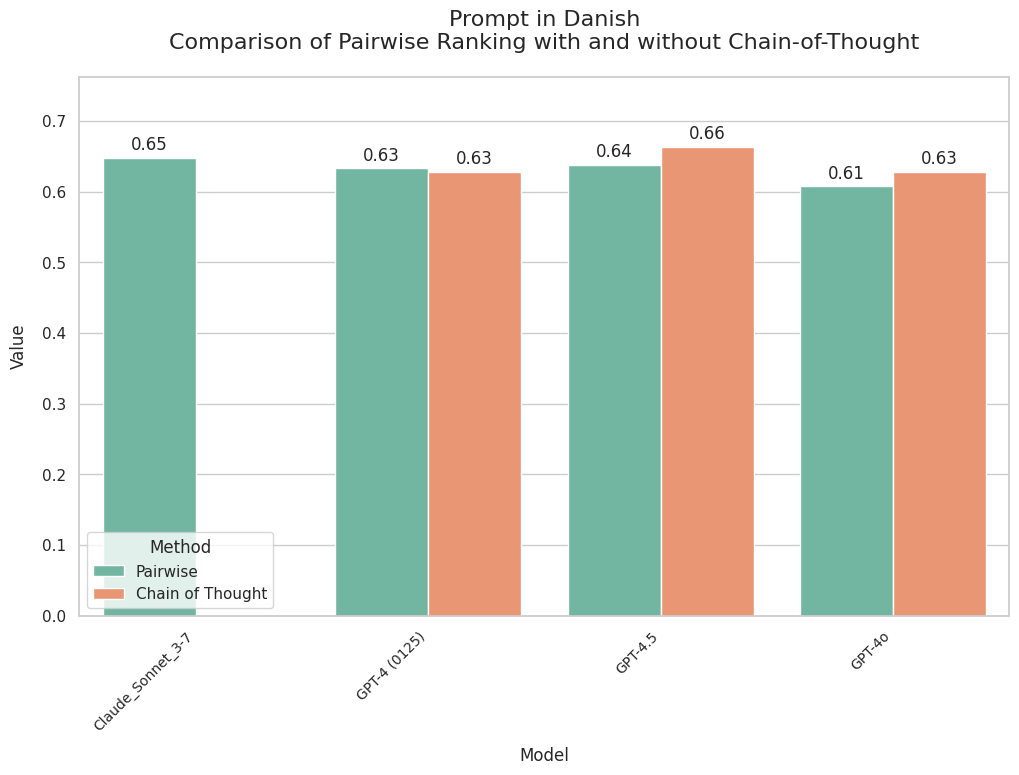

In [122]:
# Get the columns we need
pairwise_cols = [col for col in df.columns if col.endswith('_pairwise_da')]
cot_cols = [col for col in df.columns if col.endswith('_cot_da')]

# Create a new DataFrame for plotting
plot_data = []
for col in sorted(pairwise_cols + cot_cols):
    model_base = '_'.join(col.split('_')[:-2])  # Extract base model name without the suffix
    method = 'Pairwise' if col.endswith('_pairwise_da') else 'Chain of Thought'
    # Use the mean value directly since columns contain floats
    plot_data.append({
        'Model': model_base,
        'Method': method,
        'Value': df[col].mean()  # Use mean if there are multiple rows
    })

plot_df = pd.DataFrame(plot_data)

# Create more readable model names
model_mapping = {
    'gpt-4-0125-preview': 'GPT-4 (0125)',
    'gpt-4o-2024-08-06': 'GPT-4o',
    'gpt-4o-mini-2024-07-18': 'GPT-4o mini',
    'gpt-4.5-preview-2025-02-27': 'GPT-4.5',
    'gemini/gemini-1.5-pro': 'Gemini-1.5-pro',
    'gemini/gemini-2.0-flash': 'Gemini-2.0-flash',
    'claude_sonnet_37': 'Claude Sonnet 3.7',
    'gemini_25': 'Gemini 2.5 Pro (03-25)',
    'Opus_3': 'Opus 3'
}

plot_df['Model'] = plot_df['Model'].map(lambda x: model_mapping.get(x, x))

# Create the plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_df,
    x='Model',
    y='Value',
    hue='Method',
    palette=custom_palette[:2],
    errorbar=None
)

# Customize the plot
plt.title('Prompt in Danish\nComparison of Pairwise Ranking with and without Chain-of-Thought', fontsize=16, pad=20)
plt.xlabel('Model', fontsize=12, labelpad=10)
plt.ylabel('Value', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, plot_df['Value'].max() * 1.15)  # Add some space above the bars

# Add text annotations for values
for i, row in enumerate(ax.containers):
    ax.bar_label(row, fmt='%.2f', padding=3)

# Adjust legend
plt.legend(title='Method', loc='lower left', frameon=True)


In [111]:
# Make a batch prompt to feed into claude
cot = True
# Example usage
df = add_rating_prompt_column(df, 'back_translated_to_danish', 'human_edited')

# add the letter of the human edited version
df['human_edited_letter'] = df.apply(
    lambda row: 'B' if row['backtranslated_is_A'] else 'A', axis=1
)

batch = df[['prompt']].to_dict(orient='index')
prompt = create_batch_prompt_da(batch, cot=cot)
print(prompt)

Nedenfor er en dictionary med index id'er og sætninger. For hvert index, vælg den sætning, der er mest velformuleret for en person med dansk som modersmål. Fokuser ikke indholdet af teksten, kun sproget.
    Foretræk den sætning, der indeholder færrest anglicismer, grammatiske fejl, oversættelsesfejl eller andet ikke-naturlig sprogbrug.
    For hver index, skal du returnere bogstavet for den bedste sætning, altså A eller B og årsagen til dit valg. Sørg for a dictionary'en er i det rigtige format og index id'er integers og ikke strings.
    Return a dictionary like this:
    {
    0: {'bedst': 'A', 'årsag': 'Sætning B indeholder en anglicisme i form af en udansk verbalfrase ('tjekke ned')'},
    1: {'bedst': 'B', 'årsag': 'Sætning A indeholder et udansk ord (radioactive)'},
    ...
    }
    {0: {'prompt': 'A: Siden sin oprettelse er The Onion blevet et sandt parodiimperium med en trykt udgave, en hjemmeside, der tiltrak 5.000.000 unikke besøgende i oktober måned, personlige annoncer, e

In [113]:
output_dict = sonnet_37_da_cot
order_letter = 'b'
base_col_name = 'Claude_Sonnet_3-7'

#df['temp'] = pd.DataFrame.from_dict(output_dict, orient='index')['winner']
df['temp'] = pd.DataFrame.from_dict(temp, orient='index')

df[f'{base_col_name}_{order_letter}_da'] = df.apply(
    lambda row: row['temp'] == row['human_edited_letter'], axis=1)

In [114]:
df[f"{base_col_name}_{'cot' if cot else 'pairwise'}_da"] = df[[f'{base_col_name}_a_da', f'{base_col_name}_b_da']].mean(axis=1)

# Grading rubric

# Observations
- Models are not sensitive to capturing the dysfluency when only seing one sentence, even when using an extensive grading rubric
- Of the three models: 'gpt-4-0125-preview', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', only GPT 4.5 seems to have a sensitivity to dysfluency and only when prompted well.
- Given a sentence with multiple dysfluency errors, it detects them well, but overall, it only scores sentences with dysfluency marginally lower than its fluent counterparts

In [5]:
df = pd.read_json('../translations/back_translation/danish_fluency_edits_llm.jsonl', lines=True)

In [ ]:
def create_prompt_rating(text:str):
    prompt=f"""Grade the following sentence according to this grading rubric. 
    <sentence>{text}</sentence>
    
    **Criterion **
    Danish Language Fluency Grading Rubric

    1 Point: Minimal Fluency

    Vocabulary: Significant repetition and many direct translations from English or inappropriate use of non-Danish words such as radioactive. 
    Pronunciation/Flow: Text is choppy and disconnected, would sound unnatural to native speakers
    Sentence Structure: Almost exclusively simple or fragmented sentences arranged in an unnatural sequence
    Idioms: No awareness of Danish cultural context in language use

    2 Points: Basic Fluency

    Vocabulary: Occasional use of non-Danish words or direct translations, inappropriate use of non-Danish words such as radioactive, but also using direct translations of words that should not be translated, e.g., startup, pitch, binge-watching, influencer, mindfulness, ghosting. 
    Pronunciation/Flow: Text reads with a distinctly non-Danish cadence and would sound unnatural when read aloud
    Sentence Structure: Predominantly simple sentences with awkward attempts at complexity, using transitive verbs as inttansitive verbs or vice versa
    Idioms: Minimal awareness of Danish idioms and verbal phrases

    3 Points: Intermediate Fluency

    Vocabulary: Adequate vocabulary for most situations, but limited idiomatic expressions and unappropriate wording
    Pronunciation/Flow: Text has a somewhat unnatural rhythm that would be noticeable to native speakers
    Sentence Structure: Mix of simple and complex sentences, but reliance on certain patterns
    Idioms: Some awareness of Danish idioms and verbal phrases, but still some errors that are directly translated from English, e.g., 'jeg bryder problemet ned'

    4 Points: Advanced Fluency

    Vocabulary: Broad vocabulary with good use of idioms, though occasional imprecise word choice
    Pronunciation/Flow: Text flows naturally with only occasional awkward phrasing
    Sentence Structure: Good variety of complex sentence structures with minor awkwardness
    Idioms: Generally appropriate use of Danish idioms and verbal phrases with occasional slight misuse

    5 Points: Native-Like Fluency
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Pronunciation/Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions.

    ** Format 
    List all errors between the tags <reason> </reason>. In case of no fluency errors, write 'None' between the tags.
    Give your score (1-5) between the tags <score> </score>
    """

    return prompt

def create_extensive_pairwise(candidate_A:str, candidate_B:str, cot=True):
    prompt=f"""Grade the following two sentences according to this grading rubric. 
    A: {candidate_A}
    B: {candidate_B}
    
    **Criterion **
    Danish Language Fluency Grading Rubric

    1 Point: Minimal Fluency

    Vocabulary: Significant repetition and many direct translations from English or inappropriate use of non-Danish words such as radioactive. 
    Pronunciation/Flow: Text is choppy and disconnected, would sound unnatural to native speakers
    Sentence Structure: Almost exclusively simple or fragmented sentences arranged in an unnatural sequence
    Idioms: No awareness of Danish cultural context in language use

    2 Points: Basic Fluency

    Vocabulary: Occasional use of non-Danish words or direct translations, inappropriate use of non-Danish words such as radioactive, but also using direct translations of words that should not be translated, e.g., startup, pitch, binge-watching, influencer, mindfulness, ghosting. 
    Pronunciation/Flow: Text reads with a distinctly non-Danish cadence and would sound unnatural when read aloud
    Sentence Structure: Predominantly simple sentences with awkward attempts at complexity, using transitive verbs as inttansitive verbs or vice versa
    Idioms: Minimal awareness of Danish idioms and verbal phrases

    3 Points: Intermediate Fluency

    Vocabulary: Adequate vocabulary for most situations, but limited idiomatic expressions and unappropriate wording
    Pronunciation/Flow: Text has a somewhat unnatural rhythm that would be noticeable to native speakers
    Sentence Structure: Mix of simple and complex sentences, but reliance on certain patterns
    Idioms: Some awareness of Danish idioms and verbal phrases, but still some errors that are directly translated from English, e.g., 'jeg bryder problemet ned'

    4 Points: Advanced Fluency

    Vocabulary: Broad vocabulary with good use of idioms, though occasional imprecise word choice
    Pronunciation/Flow: Text flows naturally with only occasional awkward phrasing
    Sentence Structure: Good variety of complex sentence structures with minor awkwardness
    Idioms: Generally appropriate use of Danish idioms and verbal phrases with occasional slight misuse

    5 Points: Native-Like Fluency
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Pronunciation/Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions.

    ** Format 
    List all errors between the tags <candidate_A_errors> </candidate_A_errors> and <candidate_B_errors> </candidate_B_errors>. In case of no fluency errors, write 'None' between the tags.
    Return the the most fluent candidate letter between these tags: <winner> </winner>, e.g A or B
    """

    return prompt


100%|██████████| 98/98 [02:25<00:00,  1.48s/it]


       gpt-4-0125-preview_dysfluent_sent_score_score  \
count                                           98.0   
mean                                             5.0   
std                                              0.0   
min                                              5.0   
25%                                              5.0   
50%                                              5.0   
75%                                              5.0   
max                                              5.0   

       gpt-4-0125-preview_fluent_sent_score_score  
count                                        96.0  
mean                                          5.0  
std                                           0.0  
min                                           5.0  
25%                                           5.0  
50%                                           5.0  
75%                                           5.0  
max                                           5.0  


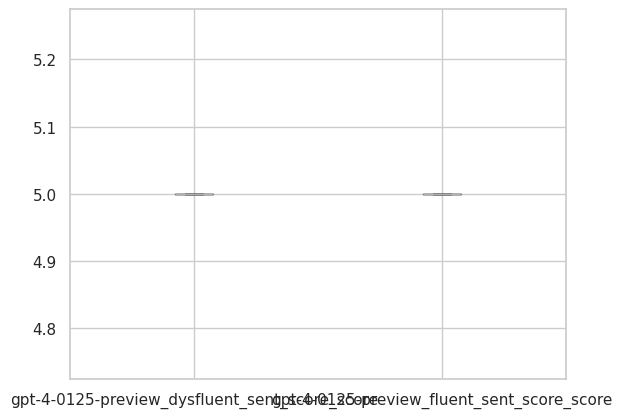

100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


       gpt-4o-2024-08-06_dysfluent_sent_score_score  \
count                                     98.000000   
mean                                       4.928571   
std                                        0.358979   
min                                        3.000000   
25%                                        5.000000   
50%                                        5.000000   
75%                                        5.000000   
max                                        5.000000   

       gpt-4o-2024-08-06_fluent_sent_score_score  
count                                  98.000000  
mean                                    4.857143  
std                                     0.537271  
min                                     2.000000  
25%                                     5.000000  
50%                                     5.000000  
75%                                     5.000000  
max                                     5.000000  


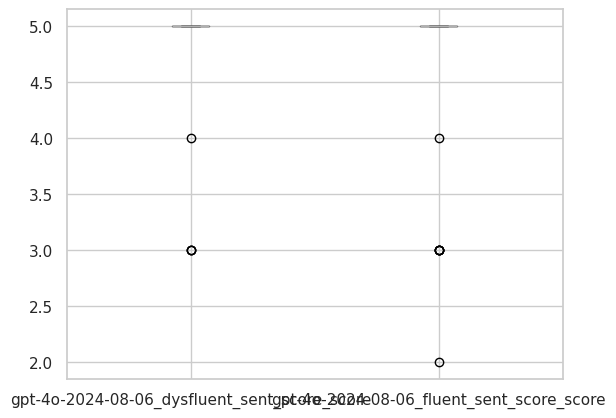

100%|██████████| 98/98 [08:48<00:00,  5.39s/it]


       gpt-4.5-preview-2025-02-27_dysfluent_sent_score_score  \
count                                              98.000000   
mean                                                4.428571   
std                                                 0.703452   
min                                                 3.000000   
25%                                                 4.000000   
50%                                                 5.000000   
75%                                                 5.000000   
max                                                 5.000000   

       gpt-4.5-preview-2025-02-27_fluent_sent_score_score  
count                                           98.000000  
mean                                             4.489796  
std                                              0.646081  
min                                              3.000000  
25%                                              4.000000  
50%                                              5.000000  
75%

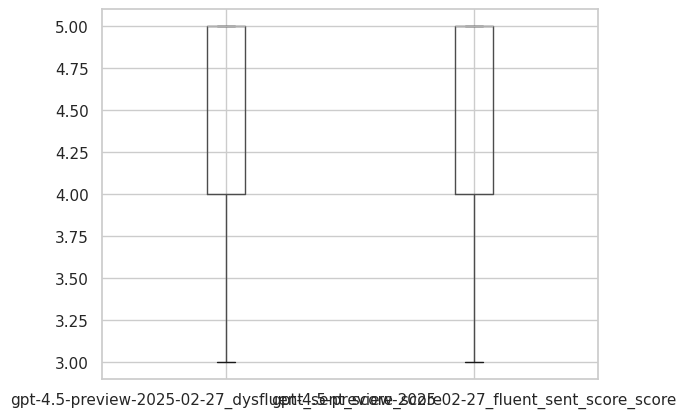

In [10]:
models = ['gpt-4-0125-preview', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
for model in models:
    df[f'{model}_dysfluent_sent_score'] = df['back_translated_to_danish'].progress_map(lambda x: call_litellm(create_prompt_rating(x), model))
    df[f'{model}_fluent_sent_score'] = df['human_edited'].progress_map(lambda x: call_litellm(create_prompt_rating(x), model))
    # extracting the score
    df[f'{model}_dysfluent_sent_score_score'] = df[f'{model}_dysfluent_sent_score'].map(lambda x: int(BeautifulSoup(x).find('score').text) if BeautifulSoup(x).find('score') else None)
    df[f'{model}_fluent_sent_score_score'] = df[f'{model}_fluent_sent_score'].map(lambda x: int(BeautifulSoup(x).find('score').text) if BeautifulSoup(x).find('score') else None)
    print( df[[f'{model}_dysfluent_sent_score_score', f'{model}_fluent_sent_score_score']].describe())
    df[[f'{model}_dysfluent_sent_score_score', f'{model}_fluent_sent_score_score']].boxplot()

    plt.show()

In [ ]:
# Qualitative inspecion of a sentence with clear dysflyency errors
sentence = "Det er almindeligt at de forsøger at skjule deres lidelser. Tro det eller ej, men de har en tendens til at holde alle deres problemer, bekymringer og nostalgi indenfor. Men nogle gange, når skuffelsen dukker op igen, blusser smerten straks følelserne op"
print('gpt-4o-2024-08-06', call_litellm(create_prompt_rating(sentence), 'gpt-4o-2024-08-06'))
print('gpt-4-0125-preview', call_litellm(create_prompt_rating(sentence), 'gpt-4-0125-preview'))
print('gpt-4.5-preview-2025-02-27', call_litellm(create_prompt_rating(sentence), 'gpt-4.5-preview-2025-02-27'))


gpt-4o-2024-08-06 <reason>None</reason>  
<score>5</score>
gpt-4-0125-preview <reason>None</reason>
<score>5</score>
gpt-4.5-preview-2025-02-27 <reason>
- "Tro det eller ej, men..." is a direct translation from the English idiom "Believe it or not," which sounds slightly unnatural in Danish. A more natural Danish phrasing could be "Utroligt nok" or "Mærkeligt nok."
- "holde alle deres problemer, bekymringer og nostalgi indenfor" is awkwardly phrased. "Holde indenfor" is not idiomatic in Danish in this context. A more natural expression would be "holde deres problemer, bekymringer og nostalgiske følelser for sig selv" or "holde det inde."
- "Når skuffelsen dukker op igen, blusser smerten straks følelserne op" is awkwardly structured. The phrase "blusser smerten straks følelserne op" is incorrect. A more natural phrasing would be "Når skuffelsen dukker op igen, blusser smerten straks op" or "kommer følel


In [ ]:
# Qualitative inspecion of a sentence with clear dtsflyency errors
sentence_a = "Det er almindeligt at de forsøger at skjule deres lidelser. Tro det eller ej, men de har en tendens til at holde alle deres problemer, bekymringer og nostalgi indenfor. Men nogle gange, når skuffelsen dukker op igen, blusser smerten straks følelserne op"
sentence_b = "Det er almindeligt at de forsøger at skjule deres lidelse. Faktisk har de en tendens til at holde alle deres problemer, bekymringer og sentimentalitet inde. Men nogle gange, når skuffelsen dukker op igen, blusser smerten straks op igen"
print('gpt-4o-2024-08-06', call_litellm(create_extensive_pairwise(sentence_a, sentence_b), 'gpt-4o-2024-08-06'))
print('gpt-4-0125-preview', call_litellm(create_extensive_pairwise(sentence_a, sentence_b), 'gpt-4-0125-preview'))
print('gpt-4.5-preview-2025-02-27', call_litellm(create_extensive_pairwise(sentence_a, sentence_b), 'gpt-4.5-preview-2025-02-27'))

gpt-4o-2024-08-06 <candidate_A_errors> 
- "nostalgi" might be slightly imprecise in this context; "sentimentalitet" could be more fitting.
- The sentence "Men nogle gange, når skuffelsen dukker op igen, blusser smerten straks følelserne op" is slightly awkward in structure. The phrase "følelserne op" could be more naturally phrased as "følelserne op igen" to match the context.
</candidate_A_errors>

<candidate_B_errors> 
- The phrase "blusser smerten straks op igen" is slightly repetitive with "igen" used twice in close proximity, which could be seen as redundant.
</candidate_B_errors>

<winner> B </winner>
gpt-4-0125-preview <candidate_A_errors>
- "nostalgi" could be considered a slightly awkward choice of word in this context, "sentimentalitet" might be more appropriate as it encompasses a broader range of emotional attachment and is more commonly used in Danish to describe such feelings.
</candidate_A_errors>

<candidate_B_errors>
None
</candidate_B_errors>

<winner>
B
</winner>
gpt

In [ ]:
models = [ 'gpt-4o-2024-08-06', 'gpt-4-0125-preview', 'gpt-4.5-preview-2025-02-27']
for model in models:
    df[f'{model}_extensive_pairwise'] = df.progress_apply(lambda x: run_rating(translation=x['back_translated_to_danish'], 
                                                                               correction=x['human_edited'],
                                                                               model=model, 
                                                                               repeat=1,
                                                                               cot=True,
                                                                               rating_prompt_func=create_extensive_pairwise, 
                                                                               max_completion_tokens=600), axis=1 )
    print(df[f'{model}_extensive_pairwise'].describe())

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [09:26<00:00,  5.78s/it]


count    98.000000
mean      0.612245
std       0.340789
min       0.000000
25%       0.500000
50%       0.500000
75%       1.000000
max       1.000000
Name: gpt-4-0125-preview_extensive_pairwise, dtype: float64


100%|██████████| 98/98 [03:32<00:00,  2.17s/it]


count    98.000000
mean      0.510204
std       0.295844
min       0.000000
25%       0.500000
50%       0.500000
75%       0.500000
max       1.000000
Name: gpt-4o-2024-08-06_extensive_pairwise, dtype: float64


 39%|███▉      | 38/98 [07:02<12:32, 12.54s/it]

a and b are equally fluent.


100%|██████████| 98/98 [18:32<00:00, 11.35s/it]

count    98.000000
mean      0.647959
std       0.367558
min       0.000000
25%       0.500000
50%       0.500000
75%       1.000000
max       1.000000
Name: gpt-4.5-preview-2025-02-27_extensive_pairwise, dtype: float64


In [11]:


def create_extensive_batch_prompt(dict_of_prompts: dict):
    # Create a properly formatted string representation of the dictionary
    dict_as_string = str({k: v for k, v in dict_of_prompts.items()})
    
    prompt = f"""Below you will see a dictionary of indices and prompts. For each index, select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness, or the content of the text, only its use of language.
    Rate each candidate according to this grading rubric:

    Danish Language Fluency Grading Rubric

    1 Point: Minimal Fluency

    Vocabulary: Significant repetition and many direct translations from English or inappropriate use of non-Danish words such as radioactive. 
    Pronunciation/Flow: Text is choppy and disconnected, would sound unnatural to native speakers
    Sentence Structure: Almost exclusively simple or fragmented sentences arranged in an unnatural sequence
    Idioms: No awareness of Danish cultural context in language use

    2 Points: Basic Fluency

    Vocabulary: Occasional use of non-Danish words or direct translations, inappropriate use of non-Danish words such as radioactive, but also using direct translations of words that should not be translated, e.g., startup, pitch, binge-watching, influencer, mindfulness, ghosting. 
    Pronunciation/Flow: Text reads with a distinctly non-Danish cadence and would sound unnatural when read aloud
    Sentence Structure: Predominantly simple sentences with awkward attempts at complexity, using transitive verbs as inttansitive verbs or vice versa
    Idioms: Minimal awareness of Danish idioms and verbal phrases

    3 Points: Intermediate Fluency

    Vocabulary: Adequate vocabulary for most situations, but limited idiomatic expressions and unappropriate wording
    Pronunciation/Flow: Text has a somewhat unnatural rhythm that would be noticeable to native speakers
    Sentence Structure: Mix of simple and complex sentences, but reliance on certain patterns
    Idioms: Some awareness of Danish idioms and verbal phrases, but still some errors that are directly translated from English, e.g., 'jeg bryder problemet ned'

    4 Points: Advanced Fluency

    Vocabulary: Broad vocabulary with good use of idioms, though occasional imprecise word choice
    Pronunciation/Flow: Text flows naturally with only occasional awkward phrasing
    Sentence Structure: Good variety of complex sentence structures with minor awkwardness
    Idioms: Generally appropriate use of Danish idioms and verbal phrases with occasional slight misuse

    5 Points: Native-Like Fluency
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Pronunciation/Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions.

    For each index, return only the letter of the candidate, i.e. A or B and the reason according to the grading rubric
    Return a dictionary like this:     {{
    0: {{'winner': 'A', 'reason': 'Candidate B contains an anglicism in the form of non standard verb-particle construction ('tjekke ned')'}},
    1: {{'winner': 'B', 'reason': 'Candidate A contains a non-standard Danish word: (radioactive)'}},
    ...
    }}
    {dict_as_string}
    """

    return prompt

In [12]:
# Make a batch prompt to feed into claude

# Example usage
df = add_rating_prompt_column(df, 'back_translated_to_danish', 'human_edited')

# add the letter of the human edited version
df['human_edited_letter'] = df.apply(
    lambda row: 'B' if row['backtranslated_is_A'] else 'A', axis=1
)

batch = df[['prompt']].to_dict(orient='index')
prompt = create_extensive_batch_prompt(batch)
print(prompt)

Below you will see a dictionary of indices and prompts. For each index, select the candidate that appears more fluent to a native Danish speaker. Do not focus on the helpfulness, or the content of the text, only its use of language.
    Rate each candidate according to this grading rubric:

    Danish Language Fluency Grading Rubric

    1 Point: Minimal Fluency

    Vocabulary: Significant repetition and many direct translations from English or inappropriate use of non-Danish words such as radioactive. 
    Pronunciation/Flow: Text is choppy and disconnected, would sound unnatural to native speakers
    Sentence Structure: Almost exclusively simple or fragmented sentences arranged in an unnatural sequence
    Idioms: No awareness of Danish cultural context in language use

    2 Points: Basic Fluency

    Vocabulary: Occasional use of non-Danish words or direct translations, inappropriate use of non-Danish words such as radioactive, but also using direct translations of words that sho

In [13]:
sonnet_37_ext = {
0: {'winner': 'A', 'reason': 'Candidate A has more natural phrasing with "i oktober måned" instead of just "i oktober", which is more precise and natural in Danish.'},
1: {'winner': 'A', 'reason': 'Candidate A has better sentence structure and flow with "blev parlamentsmedlemmet... afsat for et par uger siden" maintaining a more natural Danish word order than B.'},
2: {'winner': 'B', 'reason': 'Candidate B uses the proper Danish idiomatic expression "holde lav profil" instead of the literal translation "holde sig så lavt som muligt" in A.'},
3: {'winner': 'A', 'reason': 'Candidate A uses the more natural Danish phrase "en almindelig blækpatronprinter" while B contains the anglicism "inkjet-printere".'},
4: {'winner': 'B', 'reason': 'Candidate B has more natural flow with the addition of "i dag" which provides better context and is more idiomatic in Danish.'},
5: {'winner': 'A', 'reason': 'Candidate A uses "helbredet" which is more appropriate in this context than "velfærden" in B, as it refers to health rather than welfare.'},
6: {'winner': 'B', 'reason': 'Candidate B uses more natural Danish phrasing with "nærmere bestemt" instead of "især" and "mulige kandidater" rather than "til overvejelse".'},
7: {'winner': 'B', 'reason': 'Candidate B uses "tilbyder forbindelser" which is more idiomatic in Danish for describing flight connections than "har flyruter" in A.'},
8: {'winner': 'A', 'reason': 'Both texts are identical. Since there\'s no difference, I default to A.'},
9: {'winner': 'B', 'reason': 'Candidate B has better sentence structure and clearer expression with "kom herover" instead of just "komme" and better punctuation separating the explanation.'},
10: {'winner': 'B', 'reason': 'Candidate B uses "organisationens historie" which is more specific and natural than the vaguer "fortiden" in A.'},
11: {'winner': 'A', 'reason': 'Candidate A correctly uses "Black Beauty" as a proper noun (car name) while B mistranslates it as "hans lave sorte skønhed".'},
12: {'winner': 'B', 'reason': 'Candidate B uses more natural Danish prepositions with "foran Trafalgar Square" and "langs Strand" versus the less idiomatic "forbi" in A.'},
13: {'winner': 'A', 'reason': 'Candidate A uses correct terminology with "tilslutte sig" and "tilbudte privilegier" while B has awkward phrasing with "rejse med" and "tilbuddene".'},
14: {'winner': 'A', 'reason': 'Candidate A has correct grammar with "fredelig, indsigtsfuld, behagelig eller endda ekstatisk karakter" versus B\'s incorrect agreement in "ekstatiske karakter".'},
15: {'winner': 'B', 'reason': 'Candidate B uses more natural Danish expression "overlevelsesraterne kan være halveret i forhold til" versus the more literal translation in A.'},
16: {'winner': 'B', 'reason': 'Candidate B correctly uses "sandsynligvis" and "digtene" which are more accurate in Danish than "nok" and "eposserne" in A.'},
17: {'winner': 'B', 'reason': 'Candidate B has better flow with "da deres hjerne ikke kan stimuleres ved normale metoder" versus the awkward construction in A.'},
18: {'winner': 'B', 'reason': 'Candidate B has more natural phrasing with "korte turist- eller forretningsbesøg" and "almindelig turist" without unnecessary articles.'},
19: {'winner': 'B', 'reason': 'Candidate B correctly uses "rapporterer sine penge" while A has the unnatural construction "registerer penge".'},
20: {'winner': 'B', 'reason': 'Candidate B has better flow and more accurate prepositions with "i sandsynlige sager" instead of "for sandsynlige tilfælde" in A.'},
21: {'winner': 'A', 'reason': 'Candidate A uses the proper term "nuklear industri" while B contains the less natural compound "atomenergi virksomhed".'},
22: {'winner': 'A', 'reason': 'Candidate A has better flow with "mindst 40 andre familier" versus the awkward construction "40 andre familier eller flere" in B.'},
23: {'winner': 'A', 'reason': 'Candidate A correctly uses the proper name "Planned Parenthood" while B incorrectly translates it as "familieplanlægning".'},
24: {'winner': 'A', 'reason': 'Candidate A uses more natural expressions with "blandt i de tusind år gamle ruiner" and "hedengangne slag" versus B\'s awkward "midt i de tusindårige ruiner" and "de slag, der for længst er forsvundet".'},
25: {'winner': 'A', 'reason': 'Candidate A correctly uses "Den" (referring to item) while B incorrectly uses "Han" (he). A also has better flow in describing the geographical path.'},
26: {'winner': 'A', 'reason': 'Candidate A uses the more natural "hævder" while B uses the awkward "ligner" in this context.'},
27: {'winner': 'B', 'reason': 'Candidate B properly writes out "35° vestlig længde" while A uses the abbreviated "35°V" which is less clear in flowing text.'},
28: {'winner': 'A', 'reason': 'Candidate A uses "skjult" which is more accurate than "gemt" in B, and has more natural phrasing with "deres modtagere" versus "den rette modtager".'},
29: {'winner': 'A', 'reason': 'Candidate A correctly uses "rejsebureau" consistently while B switches to "rejseagent" which is an anglicism.'},
30: {'winner': 'A', 'reason': 'Candidate A has better sentence structure and punctuation, while B has the awkward construction "der kan leve på en anden planet".'},
31: {'winner': 'A', 'reason': 'Candidate A uses the proper term "maskinoversættelse" while B uses the anglicism "oversættelsesmotorer". A also has better phrasing with "lave grove fejl" versus "fået det helt forkert".'},
32: {'winner': 'A', 'reason': 'Candidate A uses "medierne" which is more specific and appropriate than the vague "data" in B.'},
33: {'winner': 'B', 'reason': 'Candidate B has better flow with "for eksempel" placed at the end of the comparison, which is more natural in Danish.'},
34: {'winner': 'A', 'reason': 'Candidate A correctly uses "lære om sig selv" and "få et nyt perspektiv" while B has awkward phrasing with "lære om dig selv" and "få et perspektiv".'},
35: {'winner': 'A', 'reason': 'Candidate A has more natural phrasing with "stereotypt ikke klarer sig godt" versus B\'s awkward "er stereotypiseret som ikke klarer sig godt".'},
36: {'winner': 'B', 'reason': 'Candidate B uses better verb construction with "medbragte" and "ramte flere mål" versus A\'s less natural "med... flere mål".'},
37: {'winner': 'A', 'reason': 'Both texts are identical. Since there\'s no difference, I default to A.'},
38: {'winner': 'B', 'reason': 'Candidate B correctly uses the Danish name "Tutankhamons grav" rather than the French "Tombeau de Tutankhamon" in A.'},
39: {'winner': 'A', 'reason': 'Candidate A has better sentence structure with clearer temporal relationships using "da" and "om at" versus B\'s awkward construction.'},
40: {'winner': 'B', 'reason': 'Candidate B has slightly more natural phrasing with "ting som skolearbejde" versus "for eksempel skolearbejde" in A.'},
41: {'winner': 'B', 'reason': 'Candidate B uses the more natural "avis" rather than "publikation" and "parodierede" is more idiomatic than "ville parodiere".'},
42: {'winner': 'B', 'reason': 'Candidate B uses more natural Danish phrasing with "sammen med en enkelt anden person" rather than the awkward "kun med en ven" in A.'},
43: {'winner': 'B', 'reason': 'Candidate B uses the more natural "fra det sted, hvor du bor" while A uses the less idiomatic "fra det sted, hvor du kommer fra".'},
44: {'winner': 'B', 'reason': 'Candidate B correctly uses "yndlingsoverskrifter" which is more accurate than "yndlingstitler" in A, and "efter sigende" adds appropriate nuance.'},
45: {'winner': 'B', 'reason': 'Candidate B uses the more idiomatic "der er genstand for en retlig undersøgelse" versus the more literal "der er under retlig undersøgelse" in A.'},
46: {'winner': 'B', 'reason': 'Candidate B has more natural flow with "i hver sin pavillon" and "vise globale udfordringer" versus A\'s more formal "i nationale pavilloner" and "fremhæve globale spørgsmål".'},
47: {'winner': 'A', 'reason': 'Candidate A has better sentence structure, while B contains the error "vendste hjem" (should be "vendte hjem").'},
48: {'winner': 'A', 'reason': 'Candidate A correctly uses "personen, der vinkes til" while B has the awkward "personen, der vinker".'},
49: {'winner': 'A', 'reason': 'Candidate A correctly uses "blev" while B incorrectly uses "ville være" which changes the meaning and is less accurate historically.'},
50: {'winner': 'B', 'reason': 'Candidate B has more natural flow with "denne aften" and "hver især" which adds clarity compared to A.'},
51: {'winner': 'B', 'reason': 'Candidate B uses the more accurate "afsagt" for a legal judgment and has better sentence structure with "der er sendt uopfordret" than A.'},
52: {'winner': 'A', 'reason': 'Candidate A uses "udbydere" which is more commonly understood in Danish than the technical term "aggregatorer" in B.'},
53: {'winner': 'A', 'reason': 'Candidate A has more natural sentence construction and avoids the awkward phrasing "anvende denne viden på" in B.'},
54: {'winner': 'B', 'reason': 'Candidate B has more natural Danish word order beginning with "Næsten fra begyndelsen" which flows better than A\'s construction.'},
55: {'winner': 'A', 'reason': 'Candidate A correctly uses "kan følges" (can be followed) versus B\'s "følges" which implies it is already being followed.'},
56: {'winner': 'A', 'reason': 'Candidate A uses "træder ind i atmosfæren" and "give et ret let show" which are more natural than B\'s "ind i atmosfæren" and anglicism "lave et lysshow".'},
57: {'winner': 'A', 'reason': 'Candidate A uses "mestres" which is more natural than "læres" in this context, and avoids the anglicism "storytelling" used in B.'},
58: {'winner': 'B', 'reason': 'Candidate B uses "livslang interesse" which is more idiomatic in Danish than "vedvarende interesse" in A.'},
59: {'winner': 'A', 'reason': 'Candidate A uses "overvågningskameraer" which is more natural in Danish than the anglicism "CCTV-kameraer" in B.'},
60: {'winner': 'B', 'reason': 'Candidate B has better sentence structure with "hvorfor" repeated consistently, making the text flow more naturally.'},
61: {'winner': 'B', 'reason': 'Candidate B uses "mens" which flows better than "i lyset af" in A for this temporal relationship.'},
62: {'winner': 'A', 'reason': 'Candidate A has more precise language with "bliver normalt fyldt op af de anmodninger, der modtages" versus the vague "bliver normalt booket" in B.'},
63: {'winner': 'B', 'reason': 'Candidate B uses the proper Danish term "sikkerhedsindskud" while A uses the more literal "depositum".'},
64: {'winner': 'B', 'reason': 'Candidate B uses more consistent terminology with "foldninger" throughout, while A mixes "fold" and "folder".'},
65: {'winner': 'A', 'reason': 'Candidate A uses the more natural "ledt myndighederne på sporet af ham" versus B\'s awkward "fået myndighederne til at gøre det".'},
66: {'winner': 'B', 'reason': 'Candidate B avoids unnecessary repetition of "enkelt" and uses the more natural "ændrede" versus "udskiftede" in A.'},
67: {'winner': 'A', 'reason': 'Candidate A has better flow and more natural sentence structure than B\'s fragmented construction.'},
68: {'winner': 'B', 'reason': 'Candidate B has more natural Danish phrasing with "naturligt opståede sprog" and better overall sentence structure.'},
69: {'winner': 'A', 'reason': 'Candidate A uses "kontrollerede" which is more accurate than B\'s "genindsat", and avoids the awkward term "mafia-korsfarerne".'},
70: {'winner': 'B', 'reason': 'Candidate B uses the more natural compound "smerteoplevelse" and the more idiomatic "fra normal fysisk bevægelse" versus A\'s "ved normal fysisk bevægelse".'},
71: {'winner': 'B', 'reason': 'Candidate B correctly uses "daggry" (dawn) which makes more sense in context than A\'s "tidevandet" (tide).'},
72: {'winner': 'B', 'reason': 'Candidate B has more natural flow with "fransktalende Schweiz" versus A\'s wordier "i det fransktalende Schweiz".'},
73: {'winner': 'A', 'reason': 'Candidate A avoids the repetition of "advokater" that occurs in B.'},
74: {'winner': 'A', 'reason': 'Candidate A has better sentence structure with "for at muliggøre et længere ophold" versus B\'s awkward construction "på at tage et længere ophold".'},
75: {'winner': 'A', 'reason': 'Candidate A uses the simpler "den Iranske revolution" which is more natural than B\'s unnecessarily specific "den iranske islamiske revolution".'},
76: {'winner': 'A', 'reason': 'Candidate A has more natural flow avoiding the repetitive "ikke" structure in B.'},
77: {'winner': 'A', 'reason': 'Candidate A uses proper terminology with "spejderarbejdet og informationsindsamlingen" versus B\'s awkward "efterretninger".'},
78: {'winner': 'B', 'reason': 'Candidate B uses the more natural "Det reviderede lovforslag" versus A\'s wordier "Lovforslaget, efter at være blevet ændret".'},
79: {'winner': 'B', 'reason': 'Candidate B has better flow with "fra andre sprog" positioned more naturally than A\'s construction.'},
80: {'winner': 'B', 'reason': 'Candidate B has better word order with "indledningsvist ingen grund" and clearer causality with "skyldtes logistiske årsager".'},
81: {'winner': 'B', 'reason': 'Candidate B uses "lav stenmur" which is more natural in Danish than "kort stenmur" in A.'},
82: {'winner': 'B', 'reason': 'Candidate B uses the simpler term "udsættelser" which is more natural than the wordier "lejemålsudsættelser" in A.'},
83: {'winner': 'A', 'reason': 'Candidate A has better sentence construction with "har problemer med stavning" versus B\'s awkward "eller med stavning".'},
84: {'winner': 'A', 'reason': 'Candidate A has more natural phrasing with "sprækker der er fyldte" and "trækker slæder" versus B\'s less precise "sprækker fyldt" and "transporterer slæder".'},
85: {'winner': 'A', 'reason': 'Candidate A has better sentence structure with the subordinate clause at the end, while B places it awkwardly in the middle.'},
86: {'winner': 'A', 'reason': 'Candidate A correctly uses "opmærksomhedsforstyrrelse" rather than the anglicism "ADD" and has better phrase structure with "den klassiske triade definerer symptomerne".'},
87: {'winner': 'B', 'reason': 'Candidate B has better sentence structure by dividing the long sentence into two more manageable ones.'},
88: {'winner': 'A', 'reason': 'Candidate A avoids the redundant "på dagen" and uses more natural "fysiske møde" versus the anglicism "møde ansigt til ansigt" in B.'},
89: {'winner': 'B', 'reason': 'Candidate B uses the more natural term "stimuleret emission" which is the correct scientific term in Danish, while A uses a wordier translation.'},
90: {'winner': 'A', 'reason': 'Candidate A uses the more precise term "Disney-anlægget" versus B\'s less accurate "Disney-parken".'},
91: {'winner': 'B', 'reason': 'Candidate B correctly uses the compound "mærkevarerammer" while A incorrectly splits it as "mærkerammer".'},
92: {'winner': 'B', 'reason': 'Candidate B uses "brugt" which is more accurate in this context than A\'s "opfundet".'},
93: {'winner': 'B', 'reason': 'Candidate B uses "radarteknologien" which is more precise than just "radaren" in A.'},
94: {'winner': 'A', 'reason': 'Candidate A uses "Den kunstneriske begivenhed" which is more natural than the anglicism "Kunstevent\'en" in B.'},
95: {'winner': 'A', 'reason': 'Candidate A ends the sentence more naturally than B\'s awkward addition of "omkring".'},
96: {'winner': 'B', 'reason': 'Candidate B has better sentence structure with the placement of "udover camping" and uses more concise language with "uden mad" versus "uden madservice".'},
97: {'winner': 'A', 'reason': 'Candidate A is more specific with "forstå sin egen historie" and "forstå sin kultur" versus B\'s vague "forståelsen af historien" and "forståelsen af kulturen".'}
}

sonnet_37_ext ={
    0: {'winner': 'A', 'reason': 'Candidate B omits "måned" after "oktober" which makes A sound more natural in Danish'},
    1: {'winner': 'B', 'reason': 'Candidate B has better sentence structure and more appropriate word choice with "ulovlig bestikkelse" instead of "ulovlige transplantationer"'},
    2: {'winner': 'B', 'reason': 'Candidate B uses the more idiomatic Danish expression "holde sig så lavt som muligt" rather than the direct translation "holde så lav profil som muligt"'},
    3: {'winner': 'A', 'reason': 'Candidate A uses "almindelig blækpatronprinter" which is more natural in Danish than the anglicism "standard inkjet-printere"'},
    4: {'winner': 'B', 'reason': 'Candidate B includes "i dag" which creates better flow and more natural Danish expression'},
    5: {'winner': 'A', 'reason': 'Candidate A uses "helbred" which is more appropriate than "velfærd" in this medical context'},
    6: {'winner': 'B', 'reason': 'Candidate B uses "til overvejelse for" which is more natural than the awkward phrasing "som mulige kandidater for" in A'},
    7: {'winner': 'B', 'reason': 'Candidate B uses "har flyruter til" which is more idiomatic Danish than "tilbyder forbindelser til"'},
    8: {'winner': 'A', 'reason': 'Both candidates are identical'},
    9: {'winner': 'B', 'reason': 'Candidate B has better sentence structure with "kom herover" and clearer explanation of the gesture'},
    10: {'winner': 'B', 'reason': 'Candidate B uses "organisationens historie" which is more precise than the vague "fortiden" in A'},
    11: {'winner': 'A', 'reason': 'Candidate A uses "hans lave sorte skønhed" which is more fluent than the awkward "hvor lav Black Beauty var" in B'},
    12: {'winner': 'B', 'reason': 'Candidate B uses the more natural Danish expressions "forbi" and "ad Kingsway" rather than "foran" and "langs Kingsway"'},
    13: {'winner': 'B', 'reason': 'Candidate B uses "tilslutte sig" and "privilegier" which are more precise terms than "rejse med" and "tilbud" in A'},
    14: {'winner': 'B', 'reason': 'Candidate B has better flow with proper preposition usage and avoids the awkward "behagelig eller endda ekstatiske karakter"'},
    15: {'winner': 'A', 'reason': 'Candidate A uses "hurtigere" which is more accurate than "hurtigt" and has better sentence structure'},
    16: {'winner': 'B', 'reason': 'Candidate B uses the proper Danish term "eposserne" for epic poems instead of the more generic "digtene"'},
    17: {'winner': 'B', 'reason': 'Candidate B uses the proper plural "autoriteter" rather than "autoritet" and has more natural phrasing with "bliver stimuleres ved mere almindelig adfærd"'},
    18: {'winner': 'B', 'reason': 'Candidate B has better sentence structure and flow with "som turist eller forretningsrejsende" placed more naturally'},
    19: {'winner': 'B', 'reason': 'Candidate B correctly uses "rapporterer sine penge" where A has the awkward "registerer penge"'},
    20: {'winner': 'B', 'reason': 'Candidate B uses "direkte" correctly instead of "pure" and better preposition with "i sandsynlige sager" rather than "for sandsynlige tilfælde"'},
    21: {'winner': 'A', 'reason': 'Candidate A uses "atomenergi virksomhed" which is more common in Danish than the anglicism "nuklear industri"'},
    22: {'winner': 'B', 'reason': 'Candidate B uses "mindst 40" and "samme boligsnyd" which creates better flow and precision than in A'},
    23: {'winner': 'B', 'reason': 'Candidate B uses the original name "Planned Parenthood" which is correct rather than translating it to "familieplanlægning"'},
    24: {'winner': 'A', 'reason': 'Candidate A uses "blandt i de tusind år gamle ruiner" which is more natural than the awkward phrasing in B "midt i de tusindårige ruiner"'},
    25: {'winner': 'A', 'reason': 'Candidate A uses "Den" correctly referring to the object while B incorrectly uses "Han" and has less natural sentence flow'},
    26: {'winner': 'A', 'reason': 'Candidate A uses "ligner" which is more natural than "hævder" when referring to a phone number appearance'},
    27: {'winner': 'A', 'reason': 'Candidate A writes out "35° vestlig længde" which is more proper in Danish formal writing than the abbreviation "35°V"'},
    28: {'winner': 'B', 'reason': 'Candidate B uses "gemt" which is better than "skjult" in this context and "den rette modtager" is more natural than "deres modtagere"'},
    29: {'winner': 'A', 'reason': 'Candidate A consistently uses "rejsebureau" which is the correct term rather than mixing with "rejseagent"'},
    30: {'winner': 'A', 'reason': 'Candidate A has better sentence structure with proper punctuation between clauses'},
    31: {'winner': 'A', 'reason': 'Candidate A uses "Maskinoversættelse" which is the proper Danish term rather than the anglicism "Oversættelsesmotorer"'},
    32: {'winner': 'A', 'reason': 'Candidate A uses "medierne" which is more precise than the vague "data" in B'},
    33: {'winner': 'A', 'reason': 'Candidate A uses proper prepositions with "elementer fra" rather than "elementer af" and has more natural sentence structure'},
    34: {'winner': 'B', 'reason': 'Candidate B uses "om sig selv" which is the correct reflexive form in Danish rather than "om dig selv"'},
    35: {'winner': 'B', 'reason': 'Candidate B has better flow with "som stereotypt ikke klarer sig godt" rather than the awkward "som er stereotypiseret som ikke klarer sig godt"'},
    36: {'winner': 'A', 'reason': 'Candidate A uses "medbragte" and "ramte" which creates proper sentence structure while B has grammatical issues'},
    37: {'winner': 'A', 'reason': 'Both candidates are identical'},
    38: {'winner': 'B', 'reason': 'Candidate B uses the Danish name "Tutankhamons grav" rather than keeping the French "Tombeau de Tutankhamon"'},
    39: {'winner': 'A', 'reason': 'Candidate A has better sentence structure and flow than the awkward construction in B with "om at"'},
    40: {'winner': 'B', 'reason': 'Candidate B uses "ting som skolearbejde" which flows more naturally than "for eksempel skolearbejde"'},
    41: {'winner': 'B', 'reason': 'Candidate B uses "avis" and "parodierede" which is more natural Danish than the awkward "publikation" and "ville parodiere"'},
    42: {'winner': 'B', 'reason': 'Candidate B provides a more complete and naturally flowing explanation with "møde andre mennesker"'},
    43: {'winner': 'B', 'reason': 'Candidate B uses "hvor du bor" which is more natural than "hvor du kommer fra" in this context'},
    44: {'winner': 'B', 'reason': 'Candidate B uses "yndlingsoverskrifter" which is more accurate than "yndlingstitler" and "efter sigende" adds natural flow'},
    45: {'winner': 'B', 'reason': 'Candidate B uses "genstand for en retlig undersøgelse" which is more idiomatic Danish than "under retlig undersøgelse"'},
    46: {'winner': 'B', 'reason': 'Candidate B uses "nationale pavilloner" and "fremhæve globale spørgsmål" which is more natural than "i hver sin pavillon" and "vise globale udfordringer"'},
    47: {'winner': 'B', 'reason': 'Candidate B uses "tilbagevenden" which is more appropriate than the awkward "vendste hjem" in A'},
    48: {'winner': 'B', 'reason': 'Candidate B uses "vinkes til" which is the correct Danish expression rather than the awkward "vinker" in A'},
    49: {'winner': 'A', 'reason': 'Candidate A uses "blev" which is correct for historical fact rather than "ville være" which implies uncertainty'},
    50: {'winner': 'B', 'reason': 'Candidate B uses "denne aften" and "hver især" which adds more natural flow than A'},
    51: {'winner': 'B', 'reason': 'Candidate B uses "afsagt" instead of "opnået" and "der er sendt" instead of "fra uopfordret distribution" which is more natural Danish'},
    52: {'winner': 'A', 'reason': 'Candidate A uses "udbydere" which is more commonly understood in Danish than the anglicism "aggregatorer"'},
    53: {'winner': 'B', 'reason': 'Candidate B has better sentence structure and more natural flow with "som informerer om" rather than "som informerer os om"'},
    54: {'winner': 'B', 'reason': 'Candidate B starts with a more natural Danish sentence structure "Næsten fra begyndelsen gik det skidt for italienerne"'},
    55: {'winner': 'A', 'reason': 'Candidate A uses "kan følges" which is more precise than the definitive "følges" in B'},
    56: {'winner': 'A', 'reason': 'Candidate A uses "træder ind i atmosfæren" and "give et ret let show" which is more natural than "ind i atmosfæren" and "lave et lysshow"'},
    57: {'winner': 'A', 'reason': 'Candidate A uses "mestres" instead of the anglicism "storytelling" in B'},
    58: {'winner': 'B', 'reason': 'Candidate B uses "vedvarende interesse" which is more precise than "livslang interesse" and has better sentence flow'},
    59: {'winner': 'A', 'reason': 'Candidate A avoids the anglicism "CCTV-kameraer" used in B, instead using the Danish "overvågningskameraer"'},
    60: {'winner': 'B', 'reason': 'Candidate B has better sentence structure with the repetition of "hvorfor" creating more natural flow'},
    61: {'winner': 'B', 'reason': 'Candidate B uses "mens" which creates better flow than "i lyset af" in A'},
    62: {'winner': 'A', 'reason': 'Candidate A provides more precise and natural Danish expression with "blive fyldt op af de anmodninger"'},
    63: {'winner': 'A', 'reason': 'Candidate A uses "depositum" which is more common in Danish than the anglicism "sikkerhedsindskud"'},
    64: {'winner': 'A', 'reason': 'Candidate A uses "foldninger" which is the correct Danish term rather than the awkward "folder" used in B'},
    65: {'winner': 'A', 'reason': 'Candidate A uses "ledt myndighederne på sporet af ham" which is more idiomatic Danish than the vague "fået myndighederne til at gøre det"'},
    66: {'winner': 'B', 'reason': 'Candidate B uses "en enkelt nation" and "udskiftede" which is more precise than "en nation" and "ændrede" in A'},
    67: {'winner': 'A', 'reason': 'Candidate A has better sentence structure and uses "entreprenøradfærd" correctly rather than the vague "proaktiv adfærd" in B'},
    68: {'winner': 'B', 'reason': 'Candidate B has more natural flow and better explanation with "naturlige eller organiske sprog"'},
    69: {'winner': 'A', 'reason': 'Candidate A uses "mafia-krigerne" which is more accurate than the awkward "mafia-korsfarerne" in B'},
    70: {'winner': 'B', 'reason': 'Candidate B uses "opfattelse af smerte" which is more natural than "smerteoplevelse" and "ved normal fysisk bevægelse" instead of "fra normal fysisk bevægelse"'},
    71: {'winner': 'A', 'reason': 'Candidate A uses "før daggry" which is correct rather than the nonsensical "før tidevandet" in B'},
    72: {'winner': 'B', 'reason': 'Candidate B omits the unnecessary "i" before "fransktalende Schweiz" which creates better flow'},
    73: {'winner': 'B', 'reason': 'Candidate B avoids the redundancy in A where "advokater" is mentioned twice'},
    74: {'winner': 'B', 'reason': 'Candidate B has better flow with "for at muliggøre et længere ophold" and uses "lille løn" which is more natural than "lav løn"'},
    75: {'winner': 'A', 'reason': 'Candidate A uses "iranske islamiske revolution" which is more precise than just "Iranske revolution" in B'},
    76: {'winner': 'A', 'reason': 'Candidate A has better sentence flow without the repetitive "ikke" found in B'},
    77: {'winner': 'B', 'reason': 'Candidate B uses "Spejderarbejdet og informationsindsamlingen" which is more precise than the vague "efterretninger" in A'},
    78: {'winner': 'B', 'reason': 'Candidate B uses "Det reviderede lovforslag" which is more natural than the wordier explanation in A'},
    79: {'winner': 'A', 'reason': 'Candidate A has better sentence structure with "tekster på fremmedsprog på skilte" than the awkward phrasing in B'},
    80: {'winner': 'B', 'reason': 'Candidate B has better sentence structure and flow with "indledningsvist ingen grund" and the natural ordering of clauses'},
    81: {'winner': 'A', 'reason': 'Candidate A uses "lav stenmur" which is more precise in this context than "kort stenmur" in B'},
    82: {'winner': 'A', 'reason': 'Candidate A uses "udsættelser" which is more natural than the compound "lejemålsudsættelser" in B'},
    83: {'winner': 'A', 'reason': 'Candidate A has better sentence structure and uses "ved at indtaste" which is more precise than "ved at give" in B'},
    84: {'winner': 'A', 'reason': 'Candidate A uses "der er fyldte" and "trækker" which is more precise than "fyldt" and "transporterer" in B'},
    85: {'winner': 'B', 'reason': 'Candidate B has better word order with "for, med blandet succes, at forsøge at vinde sit kongerige tilbage" which flows more naturally'},
    86: {'winner': 'A', 'reason': 'Candidate A uses "ADD" which is the correct term rather than the translated "Opmærksomhedsforstyrrelse" and has better sentence structure'},
    87: {'winner': 'B', 'reason': 'Candidate B separates sentences which creates better flow than the run-on sentence in A'},
    88: {'winner': 'A', 'reason': 'Candidate A uses the more precise "møde ansigt til ansigt" rather than the anglicism "fysiske møde" in B'},
    89: {'winner': 'B', 'reason': 'Candidate B uses the full term "stimuleret emission af stråling" which is more precise than the partial term in A'},
    90: {'winner': 'B', 'reason': 'Candidate B uses "på stedet" and "Disney-anlægget" which is more natural than the awkward phrasing in A'},
    91: {'winner': 'B', 'reason': 'Candidate B uses "mærkevarerammer" which is more natural Danish than "mærkerammer" in A'},
    92: {'winner': 'B', 'reason': 'Candidate B uses "brugt" which is more accurate than "opfundet" in this context'},
    93: {'winner': 'B', 'reason': 'Candidate B uses "radarteknologien" which is more precise than just "radaren" in A'},
    94: {'winner': 'A', 'reason': 'Candidate A uses "kunstneriske begivenhed" which is proper Danish rather than the anglicism "Kunstevent\'en" in B'},
    95: {'winner': 'A', 'reason': 'Candidate A ends naturally with "med børn" rather than the awkward "med børn omkring" in B'},
    96: {'winner': 'B', 'reason': 'Candidate B has better sentence structure with "ud over camping" and uses "madservice" which is more precise than just "mad"'},
    97: {'winner': 'A', 'reason': 'Candidate A has better sentence structure and flow than the awkward phrasing in B'}
}

In [ ]:
output_dict = sonnet_37_ext
order_letter = 'b'
base_col_name = 'Claude_Sonnet_3-7'

df['temp'] = pd.DataFrame.from_dict(output_dict, orient='index')['winner']
#df['temp'] = pd.DataFrame.from_dict(temp, orient='index')

df[f'{base_col_name}_{order_letter}'] = df.apply(
    lambda row: row['temp'].strip() == row['human_edited_letter'], axis=1)
if order_letter == 'b':
    df[f"{base_col_name}_extensive"] = df[[f'{base_col_name}_a', f'{base_col_name}_b']].mean(axis=1)

# Edit sentence

In [40]:
def create_simple_edit(sentence:str, source_sentence:str):
    prompt=f"""Edit the following sentence to make it more fluent and natural for a native Danish speaker while still being an accurate translation of the source sentence. 
    <sentence>{sentence}</sentence>
    <source_sentence>{source_sentence}</source_sentence>
    Say nothing else than the edited sentence
    """
    return prompt

def create_extensive_edit(sentence:str, source_sentence:str):
    prompt = f"""Edit this sentence such that it is more natural and fluent in Danish and still an accurate translation of the given source sentence. Replace any awkward phrasing and direct translations from English and anglicisms. Use idiomatic expressions and proper Danish grammar.
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Pronunciation/Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions.
    Example: 
    Input sentence = "Det er almindeligt at de forsøger at skjule deres lidelser. Tro det eller ej, men de har en tendens til at holde alle deres problemer, bekymringer og nostalgi indenfor. Men nogle gange, når skuffelsen dukker op igen, blusser smerten straks følelserne op"
    Source sentence: "It is common that they try to hide their suffering. Believe it or not, but they tend to keep all their problems, worries and nostalgia inside. But sometimes, when the disappointment comes up again, the pain immediately flares up"
    Output sentence = "Det er almindeligt at de forsøger at skjule deres lidelse. Faktisk har de en tendens til at holde alle deres problemer, bekymringer og sentimentalitet inde. Men nogle gange, når skuffelsen dukker op igen, blusser smerten straks op igen"
    The sentence is: "{sentence}".
    The source sentence is: "{source_sentence}".
    Return the edited sentence, say nothing else."""
    return prompt

In [ ]:
df.sour

In [ ]:
df['chrf_baseline'] = df.progress_apply(lambda x: chrf.compute(predictions=[x['back_translated_to_danish']], references=[[x['human_edited'], x['human_extensive_edits']]])['score'], axis=1)

models = [ 'gpt-4o-2024-08-06', 'gpt-4-0125-preview', 'gpt-4.5-preview-2025-02-27']
for model in models:
    df[f'{model}_simple_edit'] = df.progress_apply(lambda x: call_litellm(create_simple_edit(sentence=x['back_translated_to_danish'], source_sentence=x['source_sentence_en']), model), axis=1)
    df[f'{model}_simple_edit_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x[f'{model}_simple_edit']], references=[[x['human_edited']]])['score'], axis=1)
    df[f'{model}_simple_edit_error_reduction'] = ((100-df['chrf_baseline'])-(100-df[f'{model}_simple_edit_chrf']))/(100-df[f'chrf_baseline']) 
    print(df[f'{model}_simple_edit_error_reduction'].describe())


100%|██████████| 98/98 [00:02<00:00, 37.77it/s]


count    98.000000
mean          -inf
std            NaN
min           -inf
25%      -1.051680
50%      -0.548834
75%      -0.137458
max       1.000000
Name: gpt-4o-2024-08-06_simple_edit_error_reduction, dtype: float64


100%|██████████| 98/98 [00:02<00:00, 33.24it/s]


count    98.000000
mean          -inf
std            NaN
min           -inf
25%      -2.739729
50%      -1.217234
75%      -0.675853
max       0.332991
Name: gpt-4-0125-preview_simple_edit_error_reduction, dtype: float64


 38%|███▊      | 37/98 [01:20<02:33,  2.51s/it]

In [ ]:
models = [ 'gpt-4o-2024-08-06', 'gpt-4-0125-preview', 'gpt-4.5-preview-2025-02-27']
for model in models:
    df[f'{model}_extensive_edit'] = df.progress_apply(lambda x: call_litellm(create_extensive_edit(sentence=x['back_translated_to_danish'], source_sentence=x['source_sentence_en']), model), axis=1)
    df[f'{model}_extensive_edit_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x[f'{model}_extensive_edit']],  references=[[x['human_edited'], x['human_extensive_edits']]])['score'], axis=1)
    df[f'{model}_extensive_edit_error_reduction'] = ((100-df['chrf_baseline'])-(100-df[f'{model}_extensive_edit_chrf']))/(100-df[f'chrf_baseline']) 
    print(df[f'{model}_extensive_edit_error_reduction'].describe())

count    98.000000
mean     82.687953
std       8.458277
min      56.294120
25%      77.364768
50%      83.316985
75%      88.642408
max      96.767319
Name: gpt-4o-2024-08-06_extensive_edit_chrf, dtype: float64
count    98.000000
mean     77.660275
std       8.712644
min      51.095586
25%      73.653470
50%      78.892881
75%      83.524148
max      93.780938
Name: gpt-4-0125-preview_extensive_edit_chrf, dtype: float64
count    98.000000
mean     75.998116
std       8.367355
min      54.577984
25%      71.159009
50%      76.446057
75%      80.399421
max      90.360637
Name: gpt-4.5-preview-2025-02-27_extensive_edit_chrf, dtype: float64
